In [1]:
import torch
import dgl.nn as dglnn
from dgl import from_networkx
from dgl import save_graphs, load_graphs
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline
from sklearn.utils import class_weight
import timeit

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import joblib
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load NF-Bot IoT Dataset

In [3]:
data = pd.read_csv('/g/data/kc01/na3038/ACI-IoT-2023.csv')

filtered_df = data[~data['Label'].isin(['UDP Flood', 'ARP Spoofing'])] #'UDP Flood', 'ARP Spoofing'

# Step 2: Sample 3% from each remaining class
sampled_list = []

for label, group in filtered_df.groupby('Label'):
    sample_size = int(len(group) * 0.03) if len(group) > 80000 else len(group)
    sampled = group.sample(n=sample_size, random_state=42)
    sampled_list.append(sampled)

# Combine into a single DataFrame
sampled_data = pd.concat(sampled_list).reset_index(drop=True)

# Optional: Check counts
print(sampled_data['Label'].value_counts())

Label
Ping Sweep            71928
DNS Flood             46935
Vulnerability Scan    39537
OS Scan               37524
Slowloris             18643
SYN Flood             13857
Port Scan             13238
Benign                 9878
ICMP Flood             6757
Dictionary Attack      6380
Name: count, dtype: int64


In [7]:
# data = sampled_data
# data= data.dropna()
# data.drop(columns=['Flow ID','Timestamp','Flow Bytes/s','Flow Packets/s'],inplace = True)

# data.to_csv('/g/data/kc01/na3038/sampled_ACI-IoT-23.csv', index=False)
data = pd.read_csv('/g/data/kc01/na3038/sampled_ACI-IoT-23.csv') #/content/sample_data/ACI-IoT-2023.csv
data.head()

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Connection Type
0,192.168.1.167,33586,129.250.35.251,123,17,4495,1,1,48.0,48.0,...,0.0,0.0,0.0,0.0,1.698777e+15,0.000000e+00,1.698777e+15,1.698777e+15,Benign,wired
1,192.168.1.185,58532,162.159.61.4,443,6,4100,2,1,39.0,39.0,...,0.0,0.0,0.0,0.0,1.699030e+15,0.000000e+00,1.699030e+15,1.699030e+15,Benign,wired
2,209.206.49.216,30001,192.168.1.87,47562,6,49921696,5,5,210.0,585.0,...,1016893.0,0.0,1016893.0,1016893.0,8.495168e+14,1.201398e+15,1.699034e+15,4.882695e+07,Benign,wired
3,192.168.1.9,8080,192.168.1.1,47528,6,3895428,1,2,6.0,0.0,...,0.0,0.0,0.0,0.0,1.699037e+15,0.000000e+00,1.699037e+15,1.699037e+15,Benign,wired
4,192.168.1.9,8080,192.168.1.1,46900,6,45009151,4,4,24.0,0.0,...,1.0,0.0,1.0,1.0,4.247548e+14,8.495097e+14,1.699019e+15,1.499851e+07,Benign,wired


In [8]:


## data['Src IP'] = data['Src IP'].apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))
data['Src IP'] = data['Src IP'].apply(str)
data['Src Port'] = data['Src Port'].apply(str)
data['Dst IP'] = data['Dst IP'].apply(str)
data['Dst Port'] = data['Dst Port'].apply(str)
data['Src IP'] = data['Src IP'] + ':' + data['Src Port']
data['Dst IP'] = data['Dst IP'] + ':' + data['Dst Port']
data.drop(columns=['Src Port','Dst Port'],inplace=True)
# data.drop(columns=['Label'],inplace = True)
data.rename(columns={"Label": "label"},inplace = True)

le = LabelEncoder()
le.fit_transform(data.label.values)
data['label'] = le.transform(data['label'])
label = data.label

data.drop(columns=['label'],inplace = True)
scaler = StandardScaler()
data =  pd.concat([data, label], axis=1)

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3) # random_state=123

joblib.dump(le, "/scratch/kc01/na3038/TrainedModels/aci/label_encoder.pkl")

encoder = ce.TargetEncoder(cols=['Protocol','Connection Type','Fwd PSH Flags','Bwd PSH Flags', 'Fwd URG Flags',	'Bwd URG Flags'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

cols_to_scale = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['label','Protocol','Connection Type','Fwd PSH Flags','Bwd PSH Flags', 'Fwd URG Flags',	'Bwd URG Flags'])) )
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['label'])) )
X_train['h'] = X_train[ cols_to_norm ].values.tolist()


In [2]:
le = joblib.load("/scratch/kc01/na3038/TrainedModels/aci/label_encoder.pkl")

In [11]:
X_test = encoder.transform(X_test)
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
X_test['Edge_indx'] = list(range(len(X_test.values)))

X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [42]:
cols_to_norm =['Idle Mean',
 'Packet Length Max',
 'Fwd Packets/s',
 'Bwd IAT Std',
 'Subflow Bwd Bytes',
 'Idle Std',
 'SYN Flag Count',
 'Average Packet Size',
 'Active Std',
 'Fwd Bulk Rate Avg',
 'Total Fwd Packet',
 'Total Length of Fwd Packet',
 'Total Length of Bwd Packet',
 'Fwd Packet Length Std',
 'Idle Max',
 'Flow IAT Min',
 'Fwd IAT Max',
 'Fwd Bytes/Bulk Avg',
 'Fwd Packet Length Max',
 'PSH Flag Count',
 'Fwd Packet Length Min',
 'Active Min',
 'Packet Length Variance',
 'Protocol',
 'Fwd IAT Std',
 'URG Flag Count',
 'Bwd Bulk Rate Avg',
 'Bwd Init Win Bytes',
 'Bwd Segment Size Avg',
 'Fwd IAT Total',
 'Bwd Packet/Bulk Avg',
 'Packet Length Std',
 'Subflow Fwd Bytes',
 'Subflow Fwd Packets',
 'Fwd Seg Size Min',
 'Packet Length Mean',
 'Active Mean',
 'Bwd IAT Total',
 'Flow IAT Mean',
 'Flow Duration',
 'Connection Type',
 'CWR Flag Count',
 'Bwd Bytes/Bulk Avg',
 'Fwd IAT Mean',
 'Active Max',
 'Bwd URG Flags',
 'Fwd Header Length',
 'Bwd IAT Min',
 'Fwd IAT Min',
 'Fwd URG Flags',
 'FWD Init Win Bytes',
 'Bwd Packet Length Max',
 'Bwd PSH Flags',
 'Bwd IAT Mean',
 'RST Flag Count',
 'Flow IAT Std',
 'Bwd Packet Length Std',
 'Idle Min',
 'Bwd Packet Length Min',
 'ECE Flag Count',
 'FIN Flag Count',
 'Bwd Header Length',
 'Bwd Packet Length Mean',
 'Fwd PSH Flags',
 'Down/Up Ratio',
 'ACK Flag Count',
 'Subflow Bwd Packets',
 'Bwd IAT Max',
 'Fwd Packet/Bulk Avg',
 'Total Bwd packets',
 'Bwd Packets/s',
 'Fwd Act Data Pkts',
 'Fwd Segment Size Avg',
 'Flow IAT Max',
 'Fwd Packet Length Mean',
 'Packet Length Min']

# Generate Graphs for train and test

In [13]:
G = nx.from_pandas_edgelist(X_train, "Src IP", "Dst IP", ['h','label'],create_using=nx.MultiGraph())
G = G.to_directed()
G = from_networkx(G,edge_attrs=['h','label'] )
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))
G = G.to('cuda')

In [54]:
# save_graphs("/content/drive/MyDrive/Colab Notebooks/Datasets/TrainedModels/graph.dgl", G)
file_path = "/scratch/kc01/na3038/TrainedModels/aci/graph.dgl"
# save_graphs(file_path, G)

# Load the graph
loaded_graphs, _ = load_graphs(file_path)
G = loaded_graphs[0]

# Verify the loaded graph (optional)
print(G)
G = G.to('cuda')

Graph(num_nodes=95316, num_edges=370510,
      ndata_schemes={'h': Scheme(shape=(1, 76), dtype=torch.float32)}
      edata_schemes={'train_mask': Scheme(shape=(), dtype=torch.uint8), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 76), dtype=torch.float32)})


In [29]:
G_test = nx.from_pandas_edgelist(X_test, "Src IP", "Dst IP", ['h','label','Edge_indx'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label','Edge_indx'] )

actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))
G_test = G_test.to('cuda')

In [41]:
# save_graphs("/content/drive/MyDrive/Colab Notebooks/Datasets/TrainedModels/graph_test.dgl", G_test)
file_path = "/scratch/kc01/na3038/TrainedModels/aci/graph_test.dgl"
# save_graphs(file_path, G_test)

# Load the graph
loaded_graphs, _ = load_graphs(file_path)
G_test = loaded_graphs[0]

# Verify the loaded graph (optional)
print(G_test)
G_test = G_test.to('cuda')

Graph(num_nodes=60285, num_edges=158790,
      ndata_schemes={'feature': Scheme(shape=(1, 76), dtype=torch.float32)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 76), dtype=torch.float32)})


In [5]:
file_path = "/scratch/kc01/na3038/TrainedModels/ton/graph_test_labled.dgl"
# save_graphs(file_path, G_test)

# Load the graph
loaded_graphs, _ = load_graphs(file_path)
G_test = loaded_graphs[0]

# Verify the loaded graph (optional)
print(G_test)
G_test = G_test.to('cuda')

Graph(num_nodes=60285, num_edges=158790,
      ndata_schemes={'feature': Scheme(shape=(1, 76), dtype=torch.float32)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 76), dtype=torch.float32)})


In [6]:
file_path = "/scratch/kc01/na3038/TrainedModels/aci/actual.npy"
# np.save(file_path, actual)

# Load the graph
loaded_array = np.load(file_path, allow_pickle=True)
actual = th.from_numpy(loaded_array)
actual = le.inverse_transform(actual)
print(np.unique(actual))

['Benign' 'DNS Flood' 'Dictionary Attack' 'ICMP Flood' 'OS Scan'
 'Ping Sweep' 'Port Scan' 'SYN Flood' 'Slowloris' 'Vulnerability Scan']


# Detection

In [7]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        # global emb
        # emb = th.cat([h_u, h_v], 1)
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 10)
    def forward(self, g, nfeats,efeats, edge_weight=None, feature_weight=None, embed=False):
      if edge_weight != None:
        #apply eweight one edges
        efe = []
        for i, x in enumerate(edge_weight):
          efe.append(list(th.Tensor.cpu(G.edata['h'][i][0]).detach().numpy()*th.Tensor.cpu(x).detach().numpy()))
        efe = th.FloatTensor(efe).cuda()
        efe = th.reshape(efe, (efe.shape[0], 1, efe.shape[1]))
        g.edata['h'] = efe = efe
      if feature_weight != None:
          efe= []
          weights = th.tensor(feature_weight,device='cuda')
          # weights = weights.view(1, 1, -1)
          g.edata['h'] *= weights
          efe = g.edata['h']
          g.edata['h'] = efe = efe
      h = self.gnn(g, nfeats,efeats)
      if embed:
        return h
      else:
        return self.pred(g, h)

/jobfs/145261855.gadi-pbs/ipykernel_2539450/1470260514.py:21: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/jobfs/145261855.gadi-pbs/ipykernel_2539450/1470260514.py:27: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  print('Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))


Training acc: 0.7582952976226807
Training acc: 0.7079970836639404
Training acc: 0.831416130065918
Training acc: 0.8041753172874451
Training acc: 0.7128795385360718
Training acc: 0.8507570028305054
Training acc: 0.9155433773994446
Training acc: 0.85487300157547
Training acc: 0.7874308228492737
Training acc: 0.8045045733451843
Training acc: 0.7582682967185974
Training acc: 0.8537852764129639
Training acc: 0.9851663708686829
Training acc: 0.9753798246383667
Training acc: 0.9882134795188904
Training acc: 0.7552130818367004
Training acc: 0.9868990778923035
Training acc: 0.8832392692565918
Training acc: 0.9853202104568481
Training acc: 0.990699291229248
Training acc: 0.9909475445747375
Training acc: 0.991096019744873
Training acc: 0.9921594262123108
Training acc: 0.9912822246551514
Training acc: 0.9920325875282288
Training acc: 0.9917869567871094
Training acc: 0.9927424192428589
Training acc: 0.9750154614448547
Training acc: 0.9900811910629272
217.76877946127206 seconds


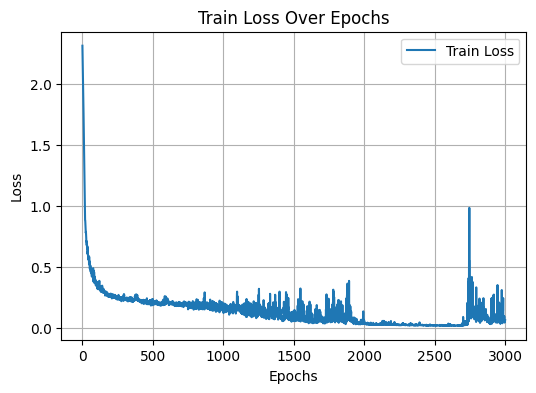

In [33]:
class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                 classes= np.unique(G.edata['label'].cpu().numpy()),
                                                 y= G.edata['label'].cpu().numpy())
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)

nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

start_time = timeit.default_timer()

train_losses = []
for epoch in range(1,3000):
    pred = model(G, nfeats, efeats).cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    train_losses.append(loss)
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
      print('Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))

train_losses =  [tensor.cpu().detach().numpy() for tensor in train_losses]
elapsed = timeit.default_timer() - start_time
print(str(elapsed) + ' seconds')

epochs = range(1, 3000)
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Save Model

In [34]:
th.save(model, "/scratch/kc01/na3038/TrainedModels/aci/model_state.pth")

In [9]:
def load_checkpoint(filepath):
  checkpoint = th.load(filepath, map_location='cuda')
  model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2)
  model.load_state_dict(checkpoint['state_dict'])
  return model

In [10]:
model = th.load("/scratch/kc01/na3038/TrainedModels/aci/model_state.pth")
print(model)

Model(
  (gnn): SAGE(
    (layers): ModuleList(
      (0): SAGELayer(
        (W_msg): Linear(in_features=152, out_features=128, bias=True)
        (W_apply): Linear(in_features=204, out_features=128, bias=True)
      )
      (1): SAGELayer(
        (W_msg): Linear(in_features=204, out_features=128, bias=True)
        (W_apply): Linear(in_features=256, out_features=128, bias=True)
      )
    )
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (pred): MLPPredictor(
    (W): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [11]:
model = model.to('cuda')

In [38]:
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

print(str(elapsed) + ' seconds')

test_pred = test_pred.argmax(1)
test_pred = th.Tensor.cpu(test_pred).detach().numpy()

# actual = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)


# Calculate the precision, recall, F2-score, and support
report = classification_report(actual, test_pred, output_dict=True)

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.4f}{metrics['recall']:<10.4f}{metrics['f1-score']:<10.4f}{accuracy:<10.4f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.4f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])


0.02839703392237425 seconds
Class          Precision Recall    F2-score  Accuracy  Support   
Benign         0.8778    0.9031    0.8903    0.9031    5852      
DNS Flood      0.9968    0.9859    0.9913    0.9859    28126     
Dictionary Attack0.9862    0.9554    0.9705    0.9554    3878      
ICMP Flood     0.9995    1.0000    0.9998    1.0000    4110      
OS Scan        0.2671    0.1268    0.1720    0.1268    22274     
Ping Sweep     0.9503    0.0839    0.1542    0.0839    43324     
Port Scan      0.1323    0.9770    0.2330    0.9770    8074      
SYN Flood      0.9928    0.9993    0.9960    0.9993    8086      
Slowloris      0.9927    0.9880    0.9903    0.9880    11082     
Vulnerability Scan0.9872    0.9825    0.9848    0.9825    23984     

Overall Accuracy:
Accuracy: 0.6157

Weighted Averages:
{'precision': 0.8312867540318243, 'recall': 0.6157188739845079, 'f1-score': 0.6046057386985041, 'support': 158790.0}


In [66]:
0.0283*1000000/158790

0.17822281000062976

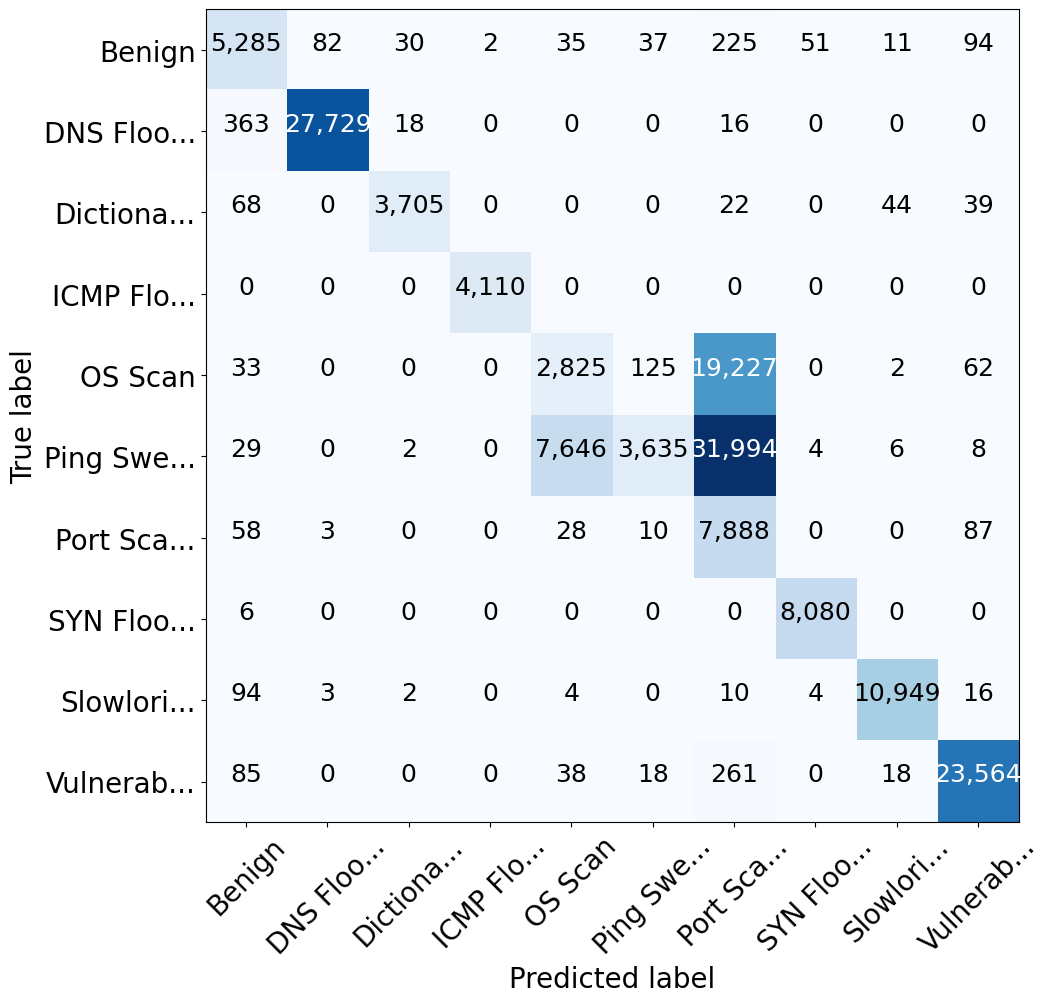

In [44]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          # title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          fontsize=20,
                          text_fontsize=18):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title,fontsize=fontsize + 2)
    # plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45,fontsize=fontsize)
        plt.yticks(tick_marks, target_names,fontsize=fontsize)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=text_fontsize,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     fontsize=text_fontsize,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label',fontsize=fontsize)
    plt.xlabel('Predicted label',fontsize=fontsize)
    plt.subplots_adjust(left=0.15, bottom=0.15)
    plt.savefig('/scratch/kc01/na3038/TrainedModels/ton/baseline-cm.png',bbox_inches='tight')
    plt.show()
max_label_len = 8  # adjust as needed
target_names = np.unique(actual)
truncated_target_names = [
    f"{label[:max_label_len]}..." if len(label) > max_label_len else label
    for label in target_names
]
plot_confusion_matrix(cm = confusion_matrix(actual, test_pred),
                      normalize    = False,
                      target_names = truncated_target_names,
                      # title        = "Confusion Matrix"
                      )

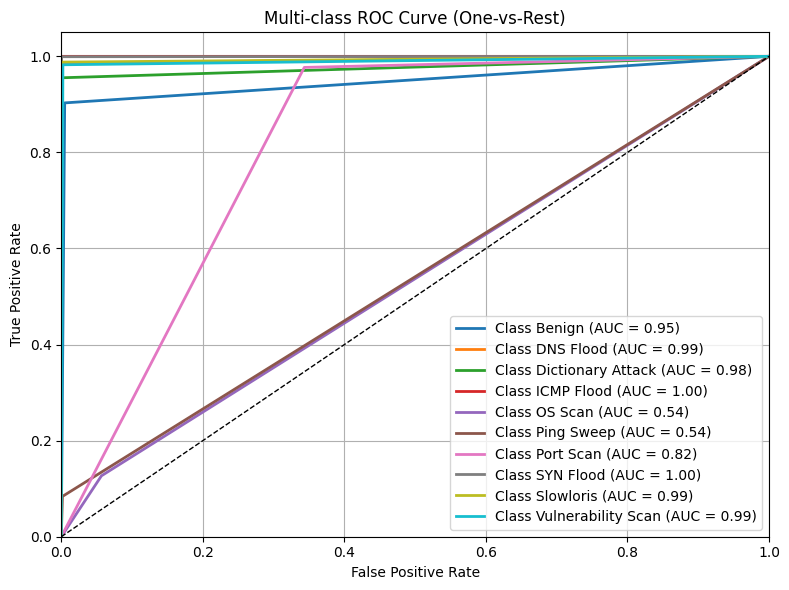

In [40]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Load example dataset
X = actual
y = test_pred
classes = np.unique(actual)
n_classes = len(classes)

X_bin = label_binarize(X, classes=classes)  # shape: (n_samples, n_classes)
y_bin = label_binarize(y, classes=classes)  # shape: (n_samples, n_classes)

# 2. Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(X_bin[:, i], y_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")

# 3. Add plot decorations
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [41]:
true_positives = {}
for i in range(len(actual)):
    if test_pred[i] == actual[i]:
      # key = G_test.edata['label'][i].cpu().item()
      key = actual[i]
      if key not in true_positives:
          true_positives[key] = []
      true_positives[key].append(G_test.edata['Edge_indx'][i].cpu().item())

In [45]:
import pickle

file_path = '/scratch/kc01/na3038/TrainedModels/aci/true_positives_sample.pkl'

# with open(file_path, 'wb') as f:
#     pickle.dump(true_positives, f)
# print(f"True positives saved to {file_path}")

In [46]:
with open(file_path, 'rb') as f:
    true_positives = pickle.load(f)

# true_positives

In [107]:
# true_positives['ddos'][:10]

# E-PGExplainer

In [47]:
import torch
from math import sqrt
import math
from tqdm import tqdm
from dgl import EID,NID,khop_out_subgraph, khop_in_subgraph, batch
from torch.optim import Adam

import torch.nn as nn

In [48]:
class ExplainerModel(nn.Module):
    def __init__(self):
        super(ExplainerModel, self).__init__()
        self.elayers = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 76)
            # nn.ReLU(),
            # nn.Linear(64, 8)
        )

    def forward(self, x):
        x = self.elayers(x)
        x = x.mean(dim=0)
        return x

In [49]:
def generate_computation_graph(graph,edge_id):
    # Extract source node-centered k-hop subgraph from the edge_id and its associated node and edge features.
    num_hops = 2
    source_node = th.Tensor.cpu(graph.edges()[0][edge_id]).detach().numpy()
    dest_node = th.Tensor.cpu(graph.edges()[1][edge_id]).detach().numpy()
    edge_h = graph.edata['h'][edge_id]
    sg, inverse_indices = khop_in_subgraph(graph, source_node, num_hops)

    return sg,inverse_indices

def create_explainer_input(pair, embeds):
        rows = pair[0]
        cols = pair[1]
        row_embeds = embeds[rows]
        col_embeds = embeds[cols]
        input_expl = th.cat([row_embeds, col_embeds], 1)
        return input_expl

In [50]:
#Updated Version
class PGExplainer(nn.Module):
    def __init__(self,model,num_hops=None,explain_graph=True,coff_budget=0.01, coff_connect=5e-4,sample_bias=0.0,):
      super(PGExplainer, self).__init__()
      self.elayers  = ExplainerModel()
      self.model = model
      self.graph_explanation = explain_graph
      self.num_hops = num_hops

      # training hyperparameters for PGExplainer
      self.coff_budget = coff_budget
      self.coff_connect = coff_connect
      self.sample_bias = sample_bias
      self.init_bias = 0.0

    def set_masks(self, graph, edge_mask=None):
        if edge_mask is None:
            num_nodes = graph.num_nodes()
            num_edges = graph.num_edges()

            init_bias = self.init_bias
            std = nn.init.calculate_gain("relu") * math.sqrt(
                2.0 / (2 * num_nodes)
            )
            self.edge_mask = torch.randn(num_edges) * std + init_bias
        else:
            self.edge_mask = edge_mask

        self.edge_mask = self.edge_mask.to(graph.device)

    def clear_masks(self):
        self.edge_mask = None
    def concrete_sample(self, w, beta=1.0, training=True):
          if training:
              bias = self.sample_bias
              random_noise = torch.rand(w.size()).to(w.device)
              random_noise = bias + (1 - 2 * bias) * random_noise
              gate_inputs = torch.log(random_noise) - torch.log(
                  1.0 - random_noise
              )
              gate_inputs = (gate_inputs + w) / beta
              gate_inputs = torch.sigmoid(gate_inputs)
          else:
              gate_inputs = torch.sigmoid(w)

          return gate_inputs

    def loss(self, prob, ori_pred):
        target_prob = prob.gather(-1, ori_pred.unsqueeze(-1))
        # 1e-6 added to prob to avoid taking the logarithm of zero
        target_prob += 1e-6
        # computing the log likelihood for a single prediction
        pred_loss = torch.mean(-torch.log(target_prob))

        # size
        edge_mask = self.sparse_mask_values
        if self.coff_budget <= 0:
            size_loss = self.coff_budget * torch.sum(edge_mask)
        else:
            size_loss = self.coff_budget * F.relu(
                torch.sum(edge_mask) - self.coff_budget
            )

        # entropy
        scale = 0.99
        edge_mask = self.edge_mask * (2 * scale - 1.0) + (1.0 - scale)
        mask_ent = -edge_mask * torch.log(edge_mask) - (
            1 - edge_mask
        ) * torch.log(1 - edge_mask)
        mask_ent_loss = self.coff_connect * torch.mean(mask_ent)

        loss = pred_loss + size_loss + mask_ent_loss
        return loss

    def train_step_node(self, edges, graph, temperature, **kwargs):
          self.model = self.model.to(graph.device)
          self.elayers = self.elayers.to(graph.device)

          if isinstance(edges, torch.Tensor):
              edges = edges.tolist()
          if isinstance(edges, int):
              edges = [edges]

          prob, _, batched_graph, inverse_indices = self.explain_node(
              edges, graph, temperature, training=True, **kwargs
          )

          pred = self.model(
              batched_graph, self.batched_feats,self.batched_efeats, **kwargs
          )
          pred = pred.argmax(-1).data

          loss = self.loss(prob[inverse_indices], pred[inverse_indices])

          del batched_graph,_, inverse_indices,prob, pred

          torch.cuda.empty_cache()

          return loss

    def explain_node(self, edges, graph, temperature=1.0, training=False, **kwargs):
          if isinstance(edges, torch.Tensor):
              edges = edges.tolist()
          if isinstance(edges, int):
              edges = [edges]

          self.model = self.model.to(graph.device)
          self.elayers = self.elayers.to(graph.device)

          if training:
              self.elayers.train()
          else:
              self.elayers.eval()

          self.model.eval()

          batched_graph = []
          batched_embed = []
          for edge_id in edges:
              sg, inverse_indices =  generate_computation_graph(graph, edge_id)
              sg.ndata["feat"]= features[sg.ndata[NID].long()]
              sg.edata["feat"]= edge_features[sg.edata[EID].long()]
              # feats = features[sg.ndata[NID].long()]
              # efeats = edge_features[sg.edata[EID].long()]
              sg.edata["train"] = torch.tensor(
                [eid in inverse_indices for eid in sg.edges(form='eid')], device=sg.device
              )

              embed = self.model(sg, sg.ndata["feat"],sg.edata["feat"],embed=True)
              embed = embed.data

              # col, row = sg.edges()
              # col_emb = embed[col.long()]
              # row_emb = embed[row.long()]
              # self_emb = embed[inverse_indices[0]].repeat(sg.num_edges(), 1)
              # need to concat these if considering combine node-based edge embeddings with raw edge features
              emb = create_explainer_input(sg.edges(), embed) # i think not needed because we do not consider on node embeddings
              batched_embed.append(emb)
              batched_graph.append(sg)
              # print("train step edge:",edge_id)

          batched_graph = batch(batched_graph)

          batched_embed = torch.cat(batched_embed)
          batched_embed = self.elayers(batched_embed) #1,8
          values = batched_embed.reshape(-1) # 8
          values = self.concrete_sample(
              values, beta=temperature, training=training
          )
          self.sparse_mask_values = values

          # col, row = batched_graph.edges()
          # reverse_eids = batched_graph.edge_ids(row, col).long()
          # edge_mask = (values + values[reverse_eids]) / 2
          # todo
          edge_mask = values

          self.set_masks(batched_graph, edge_mask)

          batched_feats = batched_graph.ndata['feat']
          batched_efeats = batched_graph.edata['h']
          # the model prediction with the updated edge mask
          logits = self.model(
              batched_graph, batched_feats, batched_efeats, feature_weight=self.edge_mask, **kwargs
          )
          probs = F.softmax(logits, dim=-1)
          # print(probs.shape)

          batched_inverse_indices = (
              batched_graph.edata["train"].nonzero().squeeze(1)
          )

          if training:
              self.batched_feats = batched_feats
              self.batched_efeats = batched_efeats
              probs = probs.data
          else:
              self.clear_masks()

          del batched_feats, batched_efeats, logits
          torch.cuda.empty_cache()
          return (
              probs,
              edge_mask,
              batched_graph,
              batched_inverse_indices,
          )

In [51]:
features = G_test.ndata['feature']
edge_features = G_test.edata['h']
labels = G_test.edata['label']

In [52]:
true_positives.keys()

dict_keys(['Vulnerability Scan', 'DNS Flood', 'Benign', 'OS Scan', 'Dictionary Attack', 'Slowloris', 'Port Scan', 'Ping Sweep', 'ICMP Flood', 'SYN Flood'])

In [53]:
len(cols_to_norm)

76

In [55]:
final_features ={key: [] for key in range(10)} 
for attack in true_positives.keys():
    print ("----------", attack,"----------")
    attack_id = le.transform([attack])[0]
    class_indices = torch.nonzero(labels == attack_id, as_tuple=False).squeeze()
    selected_indices = class_indices[torch.randperm(class_indices.size(0))][:20] # select 50 random edges from train data for each attack

    ### train the explainer for each attack:
    explainer = PGExplainer(
        model, num_hops=2, explain_graph=False, coff_budget=0.01, coff_connect=5e-4
    )
    explainer = explainer.to('cuda')

    torch.cuda.empty_cache()
    init_tmp, final_tmp = 5.0, 1.0
    optimizer_exp = torch.optim.Adam(explainer.parameters(), lr=0.01) #, weight_decay=0.001
    epochs = 5
    train_losses = []
    for epoch in range(epochs):
        tmp = float(init_tmp * np.power(final_tmp / init_tmp, epoch / epochs))
        loss = explainer.train_step_node(selected_indices, G_test, tmp)#G.edges(form='eid')
        train_losses.append(loss.item())
        optimizer_exp.zero_grad()
        loss.backward()
        optimizer_exp.step()
        print(loss.item())

    #explain with trained model
    edges_to_explain = random.sample(true_positives[attack],10)
    probs, edge_weight, bg, inverse_indices = explainer.explain_node(edges_to_explain, G_test)
    edge_weight = edge_weight.cpu().detach().numpy()


    feature_importance = {}
    for k in range(76):
      feature_importance[cols_to_norm[k]]=edge_weight[k]

    sorted_items = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)#[:20]
    for key, value in sorted_items:
      print(f'{key}: {value}') #display importance scores
      final_features[attack_id].append(cols_to_norm.index(key))

    del explainer, train_losses, probs, edge_weight, bg, inverse_indices, feature_importance, sorted_items
    torch.cuda.empty_cache()
    print('========================================================')
print(final_features)

---------- Vulnerability Scan ----------
0.518969714641571
0.6938455104827881
0.6884753108024597
0.05131302401423454
0.03942490369081497
Bwd Packet/Bulk Avg: 4.639809803724804e-12
Bwd Packet Length Mean: 3.1599137369220376e-12
Fwd IAT Max: 9.096576573594528e-13
Bwd Bulk Rate Avg: 2.953333107583167e-13
Bwd Bytes/Bulk Avg: 2.2820243958388e-13
Idle Min: 7.80560850872393e-14
Fwd Act Data Pkts: 4.82580250445782e-14
Fwd IAT Mean: 2.1252664816266524e-14
Idle Mean: 8.602180315178502e-15
Fwd IAT Std: 4.343072922103437e-15
Bwd Packet Length Min: 4.019444926363618e-15
Fwd Header Length: 3.488572320627906e-15
SYN Flag Count: 1.1298076969150968e-15
Fwd URG Flags: 9.362611978630813e-16
Bwd IAT Total: 8.81346251947572e-16
Bwd Segment Size Avg: 7.922247274901452e-16
Fwd Packet Length Mean: 5.992768689736016e-16
Packet Length Std: 5.738378225895947e-16
Bwd PSH Flags: 5.378424163421944e-16
Fwd Packet Length Max: 3.550855288514225e-16
Fwd Bytes/Bulk Avg: 3.1113444505627495e-16
Average Packet Size: 2.7876

In [45]:
all_tps = [v for values in true_positives.values() for v in values[:1000]]
len(all_tps)

3896

In [163]:
indx_to_explain = []

edges_to_explain= true_positives['Reconnaissance'][:10000]
for x in edges_to_explain:
    indx_to_explain.append((G_test.edata['Edge_indx'] == x).nonzero(as_tuple=True)[0][0].item())

df_indx = pd.DataFrame(columns = ['Edge_indx', 'label'])

for x in indx_to_explain:
    df_indx.loc[-1] = [x, G_test.edata['label'][x].item()]  # adding a row
    df_indx.index = df_indx.index + 1  # shifting index

    
df_indx = df_indx.sort_values('label')
print(df_indx)

# print('nb attacks :', len(df_indx.loc[df_indx['label'] == 1]))
# print('nb benign :', len(df_indx.loc[df_indx['label'] == 0]))
df2_indx = pd.DataFrame(columns = ['Edge_indx', 'label', 'in_out_degrees'])

      Edge_indx  label
9999          0      2
3336      49893      2
3335      49894      2
3334      49895      2
3333      49896      2
...         ...    ...
6665      17773      2
6664      17774      2
6663      17775      2
6670      17768      2
0         53732      2

[10000 rows x 2 columns]


In [363]:
min_count=20000
e=0
for x in df_indx['label'].unique():
    # select the edges having a neighborhood subgraph with 100 <= nb_edges =< 200
    list1 = df_indx.loc[df_indx['label'] == x]['Edge_indx']
    for y in list1:
      source_node = th.Tensor.cpu(G_test.edges()[0][int(y)]).detach().numpy()
      
#       sg, inverse_indices = khop_out_subgraph(G_test, source_node, 2)
#       edge_count = sg.num_edges()
#       if edge_count<min_count:
#           min_count=edge_count
#           e=y
# print(min_count,e)
      if (20 <= edge_count <= 1000) :
        print (edge_count, y)
        df2_indx.loc[-1] = [int(y), x, edge_count]  # adding a row
        df2_indx.index = df2_indx.index + 1  # shifting index
          
      # in_out_degrees = G_test.in_degrees(source_node) + G_test.out_degrees(source_node)
      # # print(in_out_degrees)
      # if (10 >= in_out_degrees.item() <= 100) :
      #   df2_indx.loc[-1] = [int(y), x, in_out_degrees.item()]  # adding a row
      #   df2_indx.index = df2_indx.index + 1  # shifting index

# print(df2_indx)
results_dff = df2_indx.apply(pd.to_numeric)
# min_rows = results_dff[results_dff['in_out_degrees'] == results_dff['in_out_degrees'].min()]
min_rows = results_dff[
    (results_dff['label'] == 2) &
    (results_dff['in_out_degrees'] == results_dff[results_dff['label'] == 2]['in_out_degrees'].min())
]
print(min_rows.head())

      Edge_indx  label  in_out_degrees
4435      53131      2               4
4434      53131      2               4
3990      50814      2               4
1308      14696      2               4
1307      14696      2               4


In [381]:
#init mask
def init_masks(graph, efeat):
  efeat_size= efeat.size()[1]
  num_edges = graph.num_edges()
  num_nodes = graph.num_nodes()
  device = efeat.device
  std=0.1
  std= nn.init.calculate_gain("relu") * sqrt (2.0/ (2 * num_nodes))
  edge_mask = nn.Parameter(th.randn(num_edges, device=device)*std)
  return edge_mask

# Regularization loss
def loss_regularize(loss, edge_mask):
    eps = 1e-15
    alpha1 = 0.005,
    alpha2 = 1.0
    beta1 = 1.0
    beta2 = 0.1

    edge_mask = edge_mask.sigmoid()
    loss = loss + th.from_numpy(alpha1 * th.Tensor.cpu(th.sum(edge_mask)).detach().numpy()).cuda()
    ent = -edge_mask * th.log(edge_mask + eps) - (
        1 - edge_mask
    ) * th.log(1 - edge_mask + eps)
    loss = loss + alpha2 * ent.mean()
    return loss


linear_threshold = 0.001  # Threshold for the slope to be considered "linear"
lookback_epochs = 200  # Number of epochs to check for linearity
# Edge mask
def explain_edges(model, edge_id, graph, node_feat, edge_feat,class_idx=None, **kwargs):
    model = model.to(graph.device)
    model.eval()

    # Extract source node-centered k-hop subgraph from the edge_id and its associated node and edge features.
    num_hops = 2
    source_node = th.Tensor.cpu(graph.edges()[0][edge_id]).detach().numpy()
    dest_node = th.Tensor.cpu(graph.edges()[1][edge_id]).detach().numpy()
    edge_h = graph.edata['h'][edge_id]
    sg, inverse_indices = khop_out_subgraph(graph, source_node, num_hops)
    print(G_test.in_degrees(source_node) + G_test.in_degrees(source_node))
    print(sg)

    # edge_indice using Edge_indx
    for indx, edge_indx in enumerate(sg.edata["Edge_indx"]):
        if (edge_indx == graph.edata["Edge_indx"][edge_id]).all() :
                edge_indice = indx
                break
    sg_edges = sg.edata[EID].long()
    sg_nodes = sg.ndata[NID].long()

    edge_feat = edge_feat[sg_edges]
    node_feat = node_feat[sg_nodes]

    edge_label_1 = sg.edata["label"][edge_indice]
    if class_idx !=None:
      edge_label_1 = (edge_label_1 == class_idx)
    # print(edge_label_1)

    # edge_mask
    edge_mask = init_masks(sg, edge_feat)
    params = [edge_mask]
    optimizer = th.optim.Adam(params, lr = 0.01)
    scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=1, epochs=250)

    # criterion2 = nn.BCEWithLogitsLoss()
    criterion2 = nn.CrossEntropyLoss()
    # criterion2 = nn.BCEWithLogitsLoss(pos_weight=th.tensor([class_weights_list[class_idx][1]], device='cuda'))
    train_mask2 = th.ones(len(sg.edata['h']), dtype=th.bool)

    xai_train_losses = []
    scaler = GradScaler()
    for epoch in range(1, 10):
        # optimizer.zero_grad()
        # Edge mask
        # logits = model(g = sg, nfeats = node_feat, efeats = edge_feat, edge_weight=edge_mask.sigmoid(),class_idx=class_idx).cuda() #edge_mask.sigmoid()
        logits = model(g = sg, nfeats = node_feat, efeats = edge_feat,edge_weight=edge_mask.sigmoid(),**kwargs).cuda()
        # predicted_classes= logits[:, edge_label_1, :].squeeze()
        # predicted_classes = th.sigmoid(logits)
        # print(predicted_classes[edge_indice],edge_label_1.float().view(-1))
        # loss11 = criterion2(predicted_classes[edge_indice], edge_label_1.float().view(-1))
        loss11 = criterion2(logits[edge_indice], edge_label_1)
        loss = loss_regularize(loss11, edge_mask)
        xai_train_losses.append(loss.item())
        # loss.backward()
        # optimizer.step()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        if epoch >= lookback_epochs:
          # Calculate the slope of the recent `lookback_epochs` losses
          recent_losses = xai_train_losses[-lookback_epochs:]
          epochs_range = np.arange(lookback_epochs)
          slope, _, _, _, _ = linregress(epochs_range, recent_losses)

          # Check if the slope is below the threshold for linearity
          if abs(slope) < linear_threshold:
              print(f"Stopping early at epoch {epoch} due to linear loss with slope {slope:.5f}")
              break

        del logits
        th.cuda.empty_cache()

    epochs = range(0, len(xai_train_losses))
    plt.figure(figsize=(6, 4))
    # xai_train_losses =  [tensor.cpu().detach().numpy() for tensor in xai_train_losses]
    plt.plot(epochs, xai_train_losses, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    edge_mask = edge_mask.detach().sigmoid()
    th.cuda.empty_cache()
    return edge_indice, sg, edge_mask, loss.item()

In [382]:
attack_edge_to_explain=0
# attack_edge_to_explain = list((G_test.edata['Edge_indx'] == 14389).nonzero(as_tuple=True)[0].cpu().detach().numpy())[0]
# attack_edge_to_explain

In [378]:
true_positives['Theft'][:10]

[3291, 5035, 6606, 11185, 13035, 18198, 19941, 20075, 32767, 33055]

tensor([628], device='cuda:0')
Graph(num_nodes=474, num_edges=16000,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})


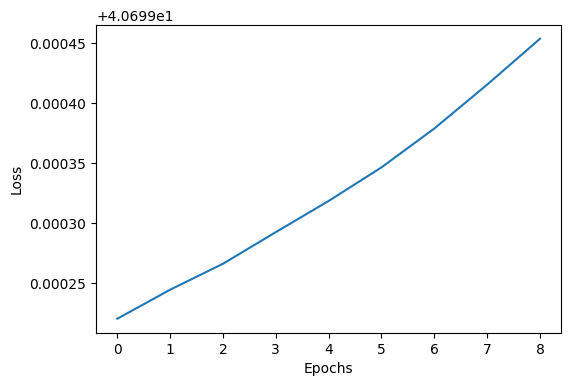

In [383]:
attck_edge_indice, attck_sub_graph, attck_edge_mask, attck_loss = explain_edges(model, attack_edge_to_explain, G_test, nfeats, efeats)#,class_idx=1

In [385]:
len(list((attck_edge_mask < 0.553).nonzero(as_tuple=True)[0].cpu().detach().numpy()))

15989

In [377]:
attck_sub_graph.edges()

(tensor([  0,   0,   0,  ..., 473, 473, 473], device='cuda:0'),
 tensor([240, 428, 330,  ..., 147,  27,  90], device='cuda:0'))

In [386]:
print(attck_sub_graph)
# edge_mask_intrusion_round = th.round(attck_edge_mask)
# unwanted_1 = list((edge_mask_intrusion_round == 0).nonzero(as_tuple=True)[0].cpu().detach().numpy())
unwanted_1 = list((attck_edge_mask < 0.553).nonzero(as_tuple=True)[0].cpu().detach().numpy())
if attck_edge_indice in unwanted_1:
    unwanted_1.remove(attck_edge_indice)

print(len(unwanted_1))

Graph(num_nodes=474, num_edges=16000,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})
15988


In [387]:
g_intrusion = dgl.remove_edges(attck_sub_graph, unwanted_1)
isolated_nodes = ((g_intrusion.in_degrees() == 0) & (g_intrusion.out_degrees() == 0)).nonzero().squeeze(1)
g_intrusion.remove_nodes(isolated_nodes)

In [388]:
g_intrusion

Graph(num_nodes=24, num_edges=12,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})

In [389]:
g_intrusion = dgl.remove_edges(attck_sub_graph, unwanted_1)
isolated_nodes = ((g_intrusion.in_degrees() == 0) & (g_intrusion.out_degrees() == 0)).nonzero().squeeze(1)
g_intrusion.remove_nodes(isolated_nodes)

nx_graph_intrusion = dgl.to_networkx(g_intrusion.cpu(), edge_attrs = g_intrusion.cpu().edata)

nx_graph_intrusion_Label = nx.get_edge_attributes(nx_graph_intrusion, "Edge_indx")
keyss = list(nx_graph_intrusion_Label.keys())
valuess = list(nx_graph_intrusion_Label.values())
edge_labelss = dict()
for indx, x in enumerate(keyss):
    edge_labelss[tuple([x[0], x[1]])] = valuess[indx].item()#le.inverse_transform([valuess[indx]]).item()


nx_graph_intrusion_Edge_indx = nx.get_edge_attributes(nx_graph_intrusion, "Edge_indx")
keyss_Edge_indx = list(nx_graph_intrusion_Edge_indx.keys())
valuess_Edge_indx = list(nx_graph_intrusion_Edge_indx.values())
orange_edge = 0
for indx, x in enumerate(valuess_Edge_indx):
    if x.item() == attck_sub_graph.edata["Edge_indx"][attck_edge_indice].item():
        orange_edge = tuple([keyss_Edge_indx[indx][0], keyss_Edge_indx[indx][1]])

# u=orange_edge[0]
# v=orange_edge[1]
# for component in nx.weakly_connected_components(nx_graph_intrusion):
#         if u in component and v in component:
#             nodes_to_keep = component
#             break

# G_nx_sub = G_nx_simple.subgraph(nodes_to_keep).copy()


In [390]:
orange_edge

(5, 13)

In [391]:
u=orange_edge[0]
v=orange_edge[1]
for component in nx.weakly_connected_components(nx_graph_intrusion):
    if u in component and v in component:
            nodes_to_keep = component
            break
print(len(nodes_to_keep))
#             break

G_nx_sub = G_nx_simple.subgraph(nodes_to_keep).copy()

2


In [374]:
nx_graph_intrusion

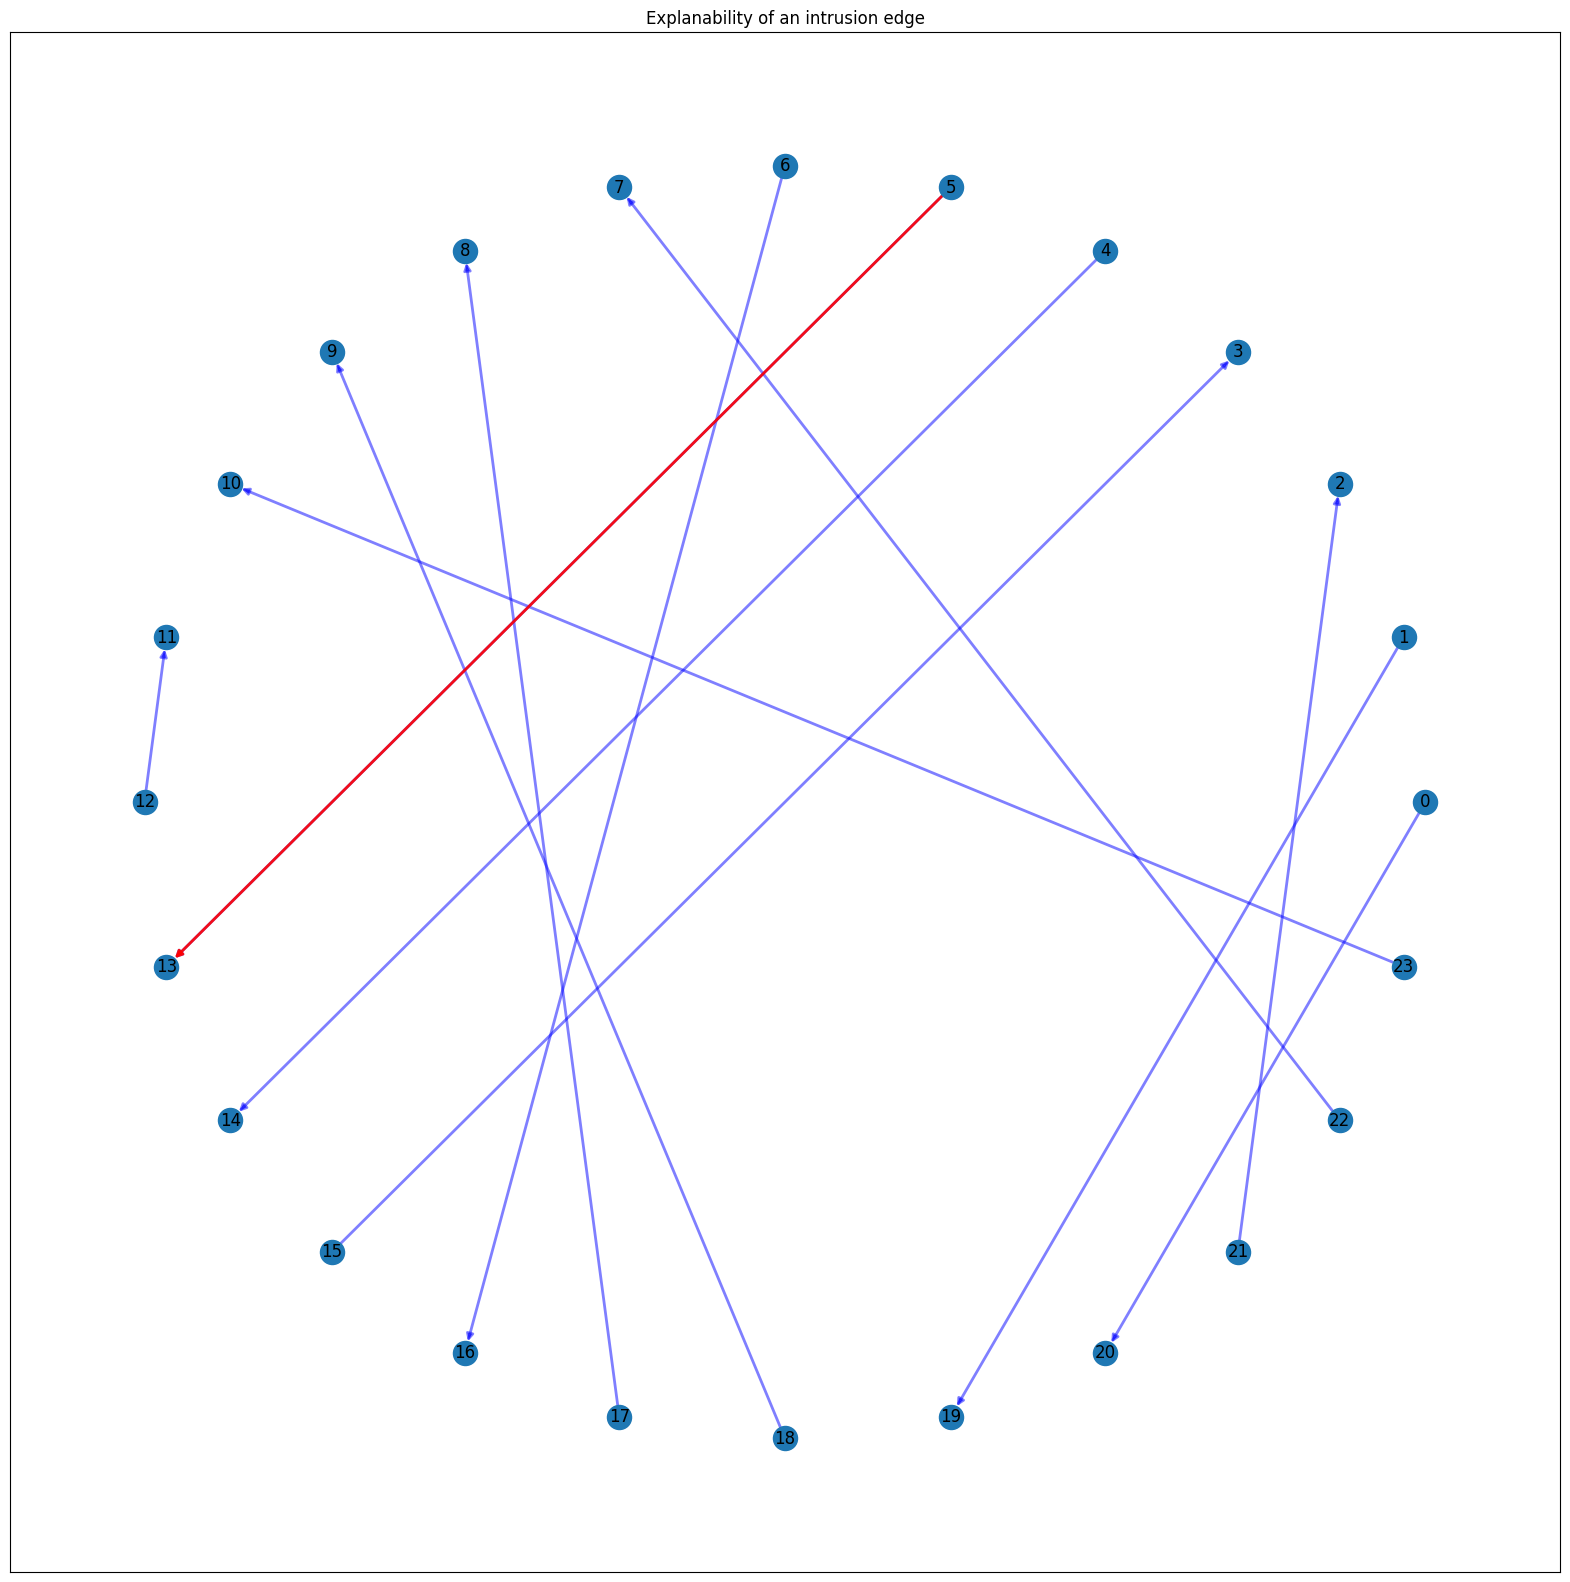

In [392]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=[20,20])
plt.title("Explanability of an intrusion edge")
plot_graph= nx_graph_intrusion
pos = nx.circular_layout(plot_graph)

nx.draw_networkx_edges(plot_graph, pos, width = 2, alpha = 0.5, edge_color = "blue")
nx.draw_networkx_nodes(plot_graph, pos)
nx.draw_networkx_labels(plot_graph, pos)

nx.draw_networkx_edges(
    plot_graph,
    pos,
    edgelist = [orange_edge],
    width = 2,
    alpha = 0.9,
    edge_color = "red",
)

# nx.draw_networkx_edge_labels(nx_graph_intrusion, pos, edge_labels = edge_labelss) #

/jobfs/144524378.gadi-pbs/ipykernel_433063/1877431623.py:21: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G, prog='twopi')  # Radial layout


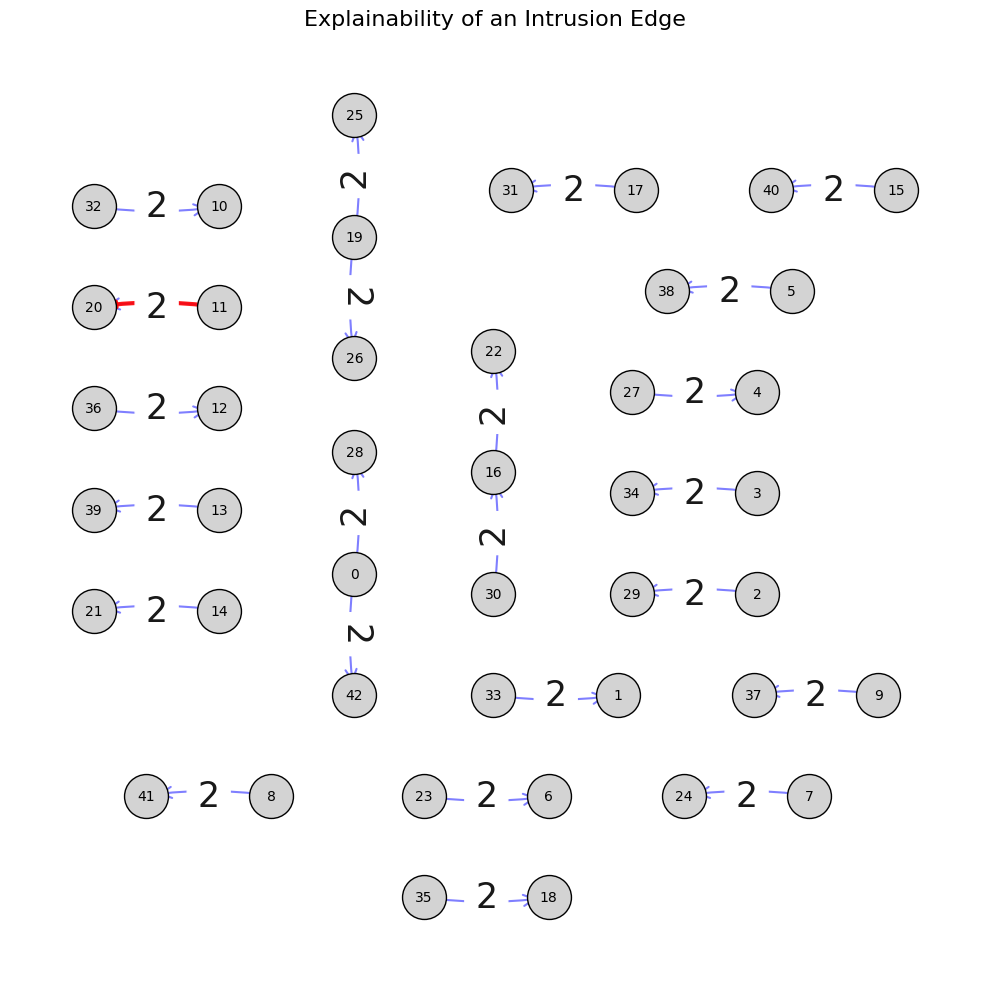

In [85]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# === Sample Graph Construction ===
# G = nx.MultiDiGraph()

# G.add_nodes_from(['Attacker', 'Gateway', 'Victim1', 'Victim2', 'Victim3'])

# G.add_edge('Attacker', 'Gateway', label='intrusion')
# G.add_edge('Gateway', 'Victim1', label='scan')
# G.add_edge('Gateway', 'Victim2', label='exploit')
# G.add_edge('Gateway', 'Victim3', label='connect')
# G.add_edge('Attacker', 'Victim3', label='secondary path')
G=nx_graph_intrusion

# highlight_edge = ('Attacker', 'Gateway')
edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}

# === Use graphviz layout via pydot ===
pos = nx.nx_pydot.graphviz_layout(G, prog='twopi')  # Radial layout

# === Plotting ===
plt.figure(figsize=(10, 10))
plt.title("Explainability of an Intrusion Edge", fontsize=16)

# Base edges with curve
nx.draw_networkx_edges(
    G,
    pos,
    width=1.5,
    alpha=0.5,
    edge_color='blue',
    arrows=True,
    arrowstyle='->',  # triangle arrow
    arrowsize=20,
    connectionstyle='arc3,rad=0.08'
)

# Highlight one edge
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=[orange_edge],
    width=3,
    alpha=0.9,
    edge_color='red',
    connectionstyle='arc3,rad=0.08'
)

# Nodes
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=1000,
    node_color='lightgray',
    edgecolors='black'
)

# Node labels
nx.draw_networkx_labels(
    G,
    pos,
    font_size=10,
    font_color='black'
)

# Transparent edge labels
transparent_black = mcolors.to_rgba('black', alpha=0.9)

nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=edge_labelss,
    font_color=transparent_black,
    font_size=25
)

plt.axis('off')
plt.tight_layout()
plt.savefig("intrusion_graph_layout.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [1]:
!pip install pydot

  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.7
    Not uninstalling pyparsing at /apps/python3/3.9.2/lib/python3.9/site-packages, outside environment /scratch/kc01/na3038/my_env
    Can't uninstall 'pyparsing'. No files were found to uninstall.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pydot]32m1/2 [pydot]


In [ ]:
def train_and_test(explainer_name, ratio_perc_to_keep,sorted_list, class_idx):
    selected_samples = sorted_list[:len(sorted_list)*ratio_perc_to_keep//100]

    class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                 classes= np.unique(G.edata['label'].cpu().numpy()),
                                                 y= G.edata['label'].cpu().numpy())
    class_weights = th.FloatTensor(class_weights).cuda()
    criterion = nn.CrossEntropyLoss(weight = class_weights)

    nfeats = G.ndata['h'][:, :, selected_samples]
    efeats = G.edata['h'][:, :, selected_samples]

    edge_label = G.edata['label']
    train_mask = G.edata['train_mask']

    model = Model(nfeats.shape[2], 128, nfeats.shape[2], F.relu, 0.2).cuda()
    opt = th.optim.Adam(model.parameters())

    # train_losses = []
    for epoch in range(1,200):
        pred = model(G, nfeats, efeats).cuda()
        loss = criterion(pred[train_mask] ,edge_label[train_mask])
        # train_losses.append(loss)
        opt.zero_grad()
        loss.backward()
        opt.step()

    node_features_test = G_test.ndata['feature'][:, :, selected_samples]
    edge_features_test = G_test.edata['h'][:, :, selected_samples]
    model.eval()
    test_pred = model(G_test, node_features_test, edge_features_test)
    test_pred = test_pred.argmax(1)
    test_pred = th.Tensor.cpu(test_pred).detach().numpy()

    report = classification_report(le.transform(actual), test_pred, output_dict=True) #labels=[class_idx]

    # Extract class 0 metrics
    class_metrics = report[str(class_idx)]

    del model,nfeats,efeats
    return {
        'dataset': ratio_perc_to_keep,
        'model': explainer_name,
        'f1_macro': class_metrics['f1-score'],
        'precision': class_metrics['precision'],
        'recall': class_metrics['recall']
    }

In [ ]:
sorted_items_pg = {0: [3, 1, 0, 4, 6, 2, 5, 7], 1: [5, 7, 0, 3, 1, 4, 6, 2], 2: [1, 4, 7, 0, 3, 5, 6, 2], 3: [7, 0, 1, 6, 3, 2, 5, 4]}
sorted_items_gnn = {0: [5, 1, 4, 7, 3, 6, 2, 0], 1: [5, 2, 4, 3, 0, 7, 6, 1], 2: [2, 4, 3, 5, 0, 7, 1, 6], 3: [4, 7, 1, 3, 2, 5, 6, 0]}

In [ ]:
last = {
    0: {
        "Precision": 0.23,
        "Recall": 0.99,
        "F1-score": 0.37
    },
    1: {
        "Precision": 0.78,
        "Recall": 0.98,
        "F1-score": 0.87
    },
    2: {
        "Precision": 1.00,
        "Recall": 0.79,
        "F1-score": 0.88
    },
   3: {
        "Precision": 0.03,
        "Recall": 0.40,
        "F1-score": 0.06
    }
}

In [ ]:
#last
# acc_ref= 0.994
f1_macro_ref=0.37
precision_ref=0.23
recall_ref=0.99

# Class          Precision Recall    F2-score  Accuracy  Support
# =================================================================
# Benign         0.23      0.99      0.37      0.994     8462
# DoS            0.78      0.98      0.87      0.979     68742
# Reconnaissance 1.00      0.79      0.88      0.787     281670
# Theft          0.03      0.40      0.06      0.402     1186

======Class type explaining: ['Benign'] =============


  0%|          | 0/4 [00:00<?, ?it/s]

Running 20


/tmp/ipython-input-57-3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 25%|██▌       | 1/4 [00:51<02:33, 51.04s/it]

Running 40


/tmp/ipython-input-57-3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 50%|█████     | 2/4 [01:41<01:41, 50.99s/it]

Running 60


/tmp/ipython-input-57-3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 75%|███████▌  | 3/4 [02:33<00:51, 51.07s/it]

Running 80


/tmp/ipython-input-57-3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  0%|          | 0/4 [00:00<?, ?it/s]

Running 20


/tmp/ipython-input-57-3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 25%|██▌       | 1/4 [00:50<02:31, 50.41s/it]

Running 40


/tmp/ipython-input-57-3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 50%|█████     | 2/4 [01:41<01:41, 50.93s/it]

Running 60


/tmp/ipython-input-57-3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 75%|███████▌  | 3/4 [02:32<00:51, 51.01s/it]

Running 80


/tmp/ipython-input-57-3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 4/4 [03:24<00:00, 51.06s/it]


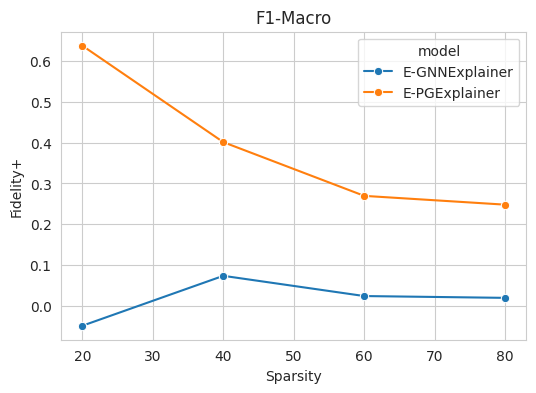

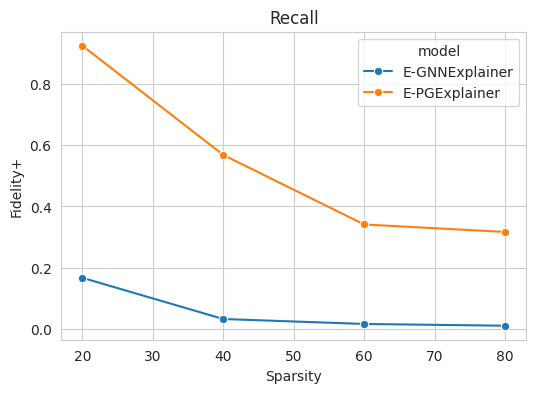

======Class type explaining: ['DoS'] =============


  0%|          | 0/4 [00:00<?, ?it/s]

Running 20


/tmp/ipython-input-57-3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  0%|          | 0/4 [00:16<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
for class_idx in range(4):
  # class_idx = 0
  print("======Class type explaining:", le.inverse_transform([class_idx]),"=============")
  #last
  # acc_ref= 0.994
  f1_macro_ref=last[class_idx]["F1-score"]
  precision_ref=last[class_idx]["Precision"]
  recall_ref=last[class_idx]["Recall"]

  # [('TCP_FLAGS', 0.5615923091769218), ('PROTOCOL', 0.2268944913521409), ('L7_PROTO', 0.02550065517425537), ('FLOW_DURATION_MILLISECONDS', -0.014227990433573723), ('OUT_BYTES', -0.08358267816365697), ('IN_BYTES', -0.426235506311059), ('IN_PKTS', -0.43372365944087504), ('OUT_PKTS', -0.4708433669991791)]
  sorted_list_gnn = sorted_items_gnn[class_idx] #[k for k, v in sorted_items_gnn[class_idx]]
  # sorted_list_gnn

  #for PG
  sorted_list_pg = sorted_items_pg[class_idx] #[k for k, v in sorted_items_pg[class_idx]] #[2,1,4,5,3,0,6,7]
  # sorted_list_pg

  df_results = []
  for i in tqdm(range(20,96,20)):
      print("Running", i)
      df_results.append(train_and_test("E-GNNExplainer", i, sorted_list_gnn, class_idx))


  for i in tqdm(range(20,96,20)):
      print("Running", i)
      df_results.append(train_and_test("E-PGExplainer", i, sorted_list_pg,class_idx))

  pdf_results = pd.DataFrame(df_results)
  # pdf_results["acc_drop"] = (acc_ref - pdf_results["acc"]) / acc_ref
  pdf_results["f1_macro_drop"] = (f1_macro_ref - pdf_results["f1_macro"]) / f1_macro_ref
  pdf_results["precision_drop"] = (precision_ref - pdf_results["precision"]) / precision_ref
  pdf_results["recall_drop"] = (recall_ref - pdf_results["recall"]) / recall_ref

  # pdf_results

  plt.figure(figsize=(6,4))
  sns.set_style(style='whitegrid')
  ax = sns.lineplot(
      data=pdf_results,
      x='dataset',
      y='f1_macro_drop',
      marker="o",
      hue="model"

  )
  #plt.ylim((-0.11),1.25)
  ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "F1-Macro")
  plt.show()
  fig = ax.get_figure()

  plt.figure(figsize=(6,4))
  sns.set_style(style='whitegrid')
  ax = sns.lineplot(
      data=pdf_results, #[(pdf_results.model=="GNNExplainer") | (pdf_results.model=="PGExplainer")],
      x='dataset',
      y='recall_drop',
      marker="o",
      hue="model"

  )
  #plt.ylim((-0.11),1.25)
  ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "Recall")
  plt.show()
  fig = ax.get_figure()


In [ ]:
#20 min for one class eval generation

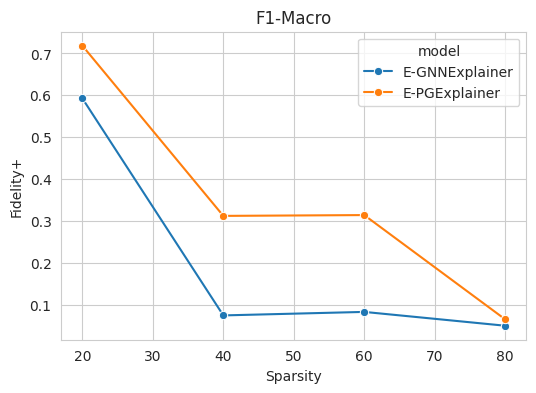

In [ ]:
plt.figure(figsize=(6,4))
sns.set_style(style='whitegrid')
ax = sns.lineplot(
    data=pdf_results, #[(pdf_results.model=="GNNExplainer") | (pdf_results.model=="PGExplainer")],
    x='dataset',
    y='f1_macro_drop',
    marker="o",
    hue="model"

)
#plt.ylim((-0.11),1.25)
ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "F1-Macro")
plt.show()
fig = ax.get_figure()

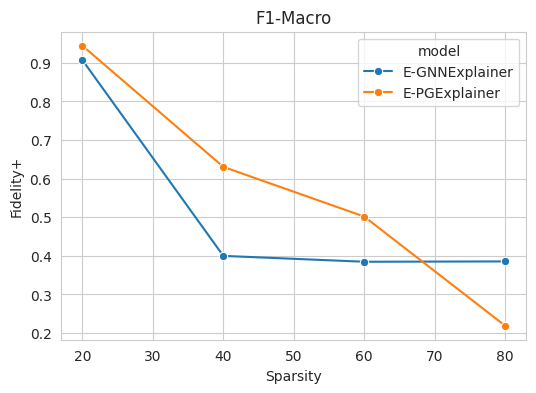

In [ ]:
plt.figure(figsize=(6,4))
sns.set_style(style='whitegrid')
ax = sns.lineplot(
    data=pdf_results, #[(pdf_results.model=="GNNExplainer") | (pdf_results.model=="PGExplainer")],
    x='dataset',
    y='recall_drop',
    marker="o",
    hue="model"

)
#plt.ylim((-0.11),1.25)
ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "Recall")
plt.show()
fig = ax.get_figure()

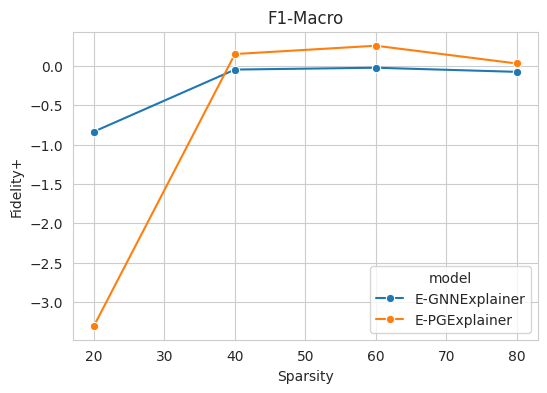

In [ ]:
plt.figure(figsize=(6,4))
sns.set_style(style='whitegrid')
ax = sns.lineplot(
    data=pdf_results, #[(pdf_results.model=="GNNExplainer") | (pdf_results.model=="PGExplainer")],
    x='dataset',
    y='precision_drop',
    marker="o",
    hue="model"

)
#plt.ylim((-0.11),1.25)
ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "Precision")
plt.show()
fig = ax.get_figure()

# OvA Model


In [20]:
global emb
global score_global
emb ={key: [] for key in range(7)}
score_global ={key: [] for key in range(7)}

In [35]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to output fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats,efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        # ipdb.set_trace()
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.classifiers = nn.ModuleList([nn.Linear(in_features * 2, out_classes) for _ in range(10)])

    def apply_edges(self, edges, class_idx, test,apply_sigmoid=False):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        logits = self.classifiers[class_idx](th.cat([h_u, h_v], 1))
        if apply_sigmoid:
            score = torch.sigmoid(logits) #logits[:,1] #torch.sigmoid(logits)[:,1]
        else:
            score = logits
        # score = logits
        # if test:
        #     emb[class_idx]= th.cat([h_u, h_v], 1)
        #     score_global[class_idx] = score
        return {'score': score}
    def forward(self, graph, h,test,class_idx=None):
        with graph.local_scope():
            graph.ndata['h'] = h
            if class_idx is not None:
              graph.apply_edges(lambda edges: self.apply_edges(edges, class_idx,test, apply_sigmoid=False))
              return graph.edata['score']
            else:
              outputs = []
              for i in range(len(self.classifiers)):
                  graph.apply_edges(lambda edges: self.apply_edges(edges, i,test,apply_sigmoid=True))
                  outputs.append(graph.edata['score'])
              return torch.stack(outputs, dim=1)

class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 1)
    def forward(self, g, nfeats,efeats, eweight=None, feature_weight=None, test=False,class_idx=None):
      if eweight != None:
            # apply eweight on the graph
            efe = []
            for i, x in enumerate(eweight):
                efe.append(list(th.Tensor.cpu(g.edata['h'][i][0]).detach().numpy() * th.Tensor.cpu(x).detach().numpy()))

            efe = th.FloatTensor(efe).cuda()
            efe = th.reshape(efe, (efe.shape[0], 1, efe.shape[1]))
            g.edata['h'] = efe = efe
      if feature_weight != None:
          efe= []
          weights = th.tensor(feature_weight,device='cuda')
          # weights = weights.view(1, 1, -1)
          g.edata['h'] *= weights
          efe = g.edata['h']
          g.edata['h'] = efe = efe
          # efeats *= weights
      h = self.gnn(g, nfeats,efeats)
      # return self.pred(g, h)
      if class_idx is not None:
        return self.pred(g, h,test,class_idx)
      else:
        # If no class specified, return predictions for all classes (used for evaluation)
        return self.pred(g, h,test)

In [22]:
from sklearn.utils import class_weight
class_weights_list = []
for i in range(10):
    binary_labels = (G.edata['label'].cpu().numpy() == i).astype(int)
    class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                  classes= np.unique(binary_labels),
                                                  y= binary_labels)
    class_weights = th.FloatTensor(class_weights).cuda()
    class_weights_list.append(class_weights)
class_weights_list

[tensor([ 0.5194, 13.3700], device='cuda:0'),
 tensor([0.6079, 2.8178], device='cuda:0'),
 tensor([ 0.5123, 20.8574], device='cuda:0'),
 tensor([ 0.5130, 19.6996], device='cuda:0'),
 tensor([0.5830, 3.5103], device='cuda:0'),
 tensor([0.6862, 1.8427], device='cuda:0'),
 tensor([ 0.5261, 10.0671], device='cuda:0'),
 tensor([0.5280, 9.4383], device='cuda:0'),
 tensor([0.5381, 7.0697], device='cuda:0'),
 tensor([0.5873, 3.3631], device='cuda:0')]

In [23]:
def train_one_vs_all(model,graph,nfeats, efeats, labels, train_mask, optimizer, num_classes):
    model.train()
    losses = []

    # For each class, train the corresponding binary classifier
    for class_idx in range(num_classes):
        label = le.inverse_transform([class_idx])[0]
        optimizer.zero_grad()
        # Forward pass
        # outputs = model(graph, nfeats, efeats,class_idx=class_idx,feature_weight=final_feature_weights[label]).cuda()
        outputs = model(graph, nfeats, efeats, class_idx=class_idx).cuda()

        #using BCELoss Function
        binary_labels = (labels == class_idx).float()
        criterion = nn.BCEWithLogitsLoss(pos_weight=th.tensor([class_weights_list[class_idx][1]], device=outputs.device))
        loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        del outputs,binary_labels, loss
        th.cuda.empty_cache()

    avg_loss = np.mean(losses)
    return avg_loss


0.24392904008273036
0.17866152170463465
0.14317054288112557
0.14927632939070462
0.1304258603413473
0.7446018327027559
0.1269738028757274


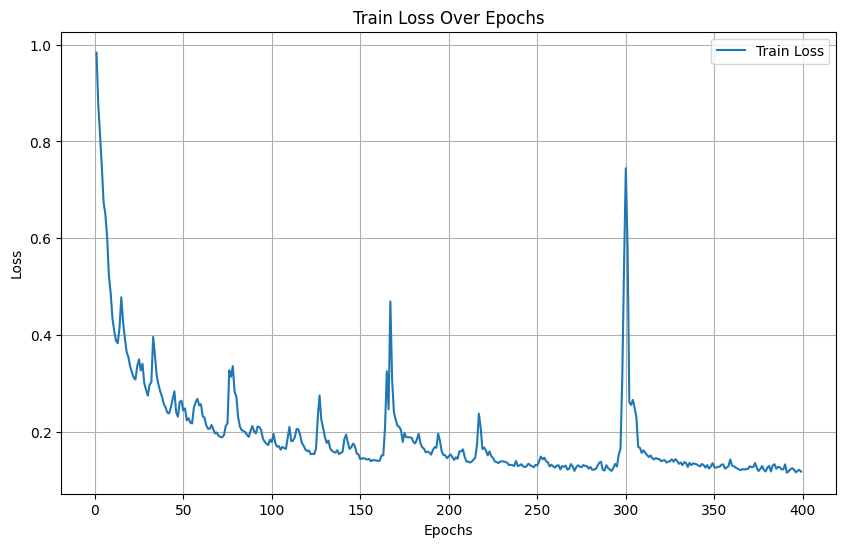

In [36]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(76, 128, 76, F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

train_losses = []
for epoch in range(1,400):#400
    avg_loss = train_one_vs_all(model,G,nfeats, efeats,  edge_label, train_mask, opt, 10)
    train_losses.append(avg_loss)
    if epoch % 50 == 0:
        print(avg_loss)

epochs = range(1, 400)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
def predict_one_vs_all(model,graph,node_feat, edge_feat):
    model.eval()

    with th.no_grad():
        # Forward pass to get binary classifier outputs for all classes
        outputs = model(graph, nfeats, efeats,test = True)
        # new_df=outputs.cpu().detach().numpy()
        # new_df=pd.DataFrame(outputs.squeeze().cpu())
        # print(outputs.squeeze().shape)
        predicted_classes = th.argmax(outputs, dim=1)  # Select the class with the highest score

    return predicted_classes #, new_df

nfeats = G_test.ndata['feature']
efeats = G_test.edata['h']
predicted_classes = predict_one_vs_all(model,G_test, nfeats ,efeats) #, new_df
predicted_classes.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Calculate the precision, recall, F2-score, and support
report = classification_report(actual, le.inverse_transform(predicted_classes.cpu()), output_dict=True)

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.4f}{metrics['recall']:<10.4f}{metrics['f1-score']:<10.4f}{accuracy:<10.4f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.4f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

Class          Precision Recall    F2-score  Accuracy  Support   
Benign         0.8339    0.9130    0.8717    0.9130    5852      
DNS Flood      0.9903    0.9886    0.9895    0.9886    28126     
Dictionary Attack0.9874    0.9727    0.9800    0.9727    3878      
ICMP Flood     0.9985    0.9995    0.9990    0.9995    4110      
OS Scan        0.8114    0.0616    0.1145    0.0616    22274     
Ping Sweep     0.6853    0.0406    0.0766    0.0406    43324     
Port Scan      0.1132    0.9700    0.2027    0.9700    8074      
SYN Flood      0.9943    0.9998    0.9970    0.9998    8086      
Slowloris      0.9940    0.9735    0.9836    0.9735    11082     
Vulnerability Scan0.9871    0.9855    0.9863    0.9855    23984     

Overall Accuracy:
Accuracy: 0.5951

Weighted Averages:
{'precision': 0.8317431393110615, 'recall': 0.5951130423830217, 'f1-score': 0.5728359434984288, 'support': 158790.0}


In [71]:
# 0.02839703392237425 seconds
# Class          Precision Recall    F2-score  Accuracy  Support   
# =================================================================
# Benign         0.8778    0.9031    0.8903    0.9031    5852      
# DNS Flood      0.9968    0.9859    0.9913    0.9859    28126     
# Dictionary Attack0.9862    0.9554    0.9705    0.9554    3878      
# ICMP Flood     0.9995    1.0000    0.9998    1.0000    4110      
# OS Scan        0.2671    0.1268    0.1720    0.1268    22274     
# Ping Sweep     0.9503    0.0839    0.1542    0.0839    43324     
# Port Scan      0.1323    0.9770    0.2330    0.9770    8074      
# SYN Flood      0.9928    0.9993    0.9960    0.9993    8086      
# Slowloris      0.9927    0.9880    0.9903    0.9880    11082     
# Vulnerability Scan0.9872    0.9825    0.9848    0.9825    23984     

# Overall Accuracy:
# Accuracy: 0.6157

# Weighted Averages:
# {'precision': 0.8312867540318243, 'recall': 0.6157188739845079, 'f1-score': 0.6046057386985041, 'support': 158790.0}

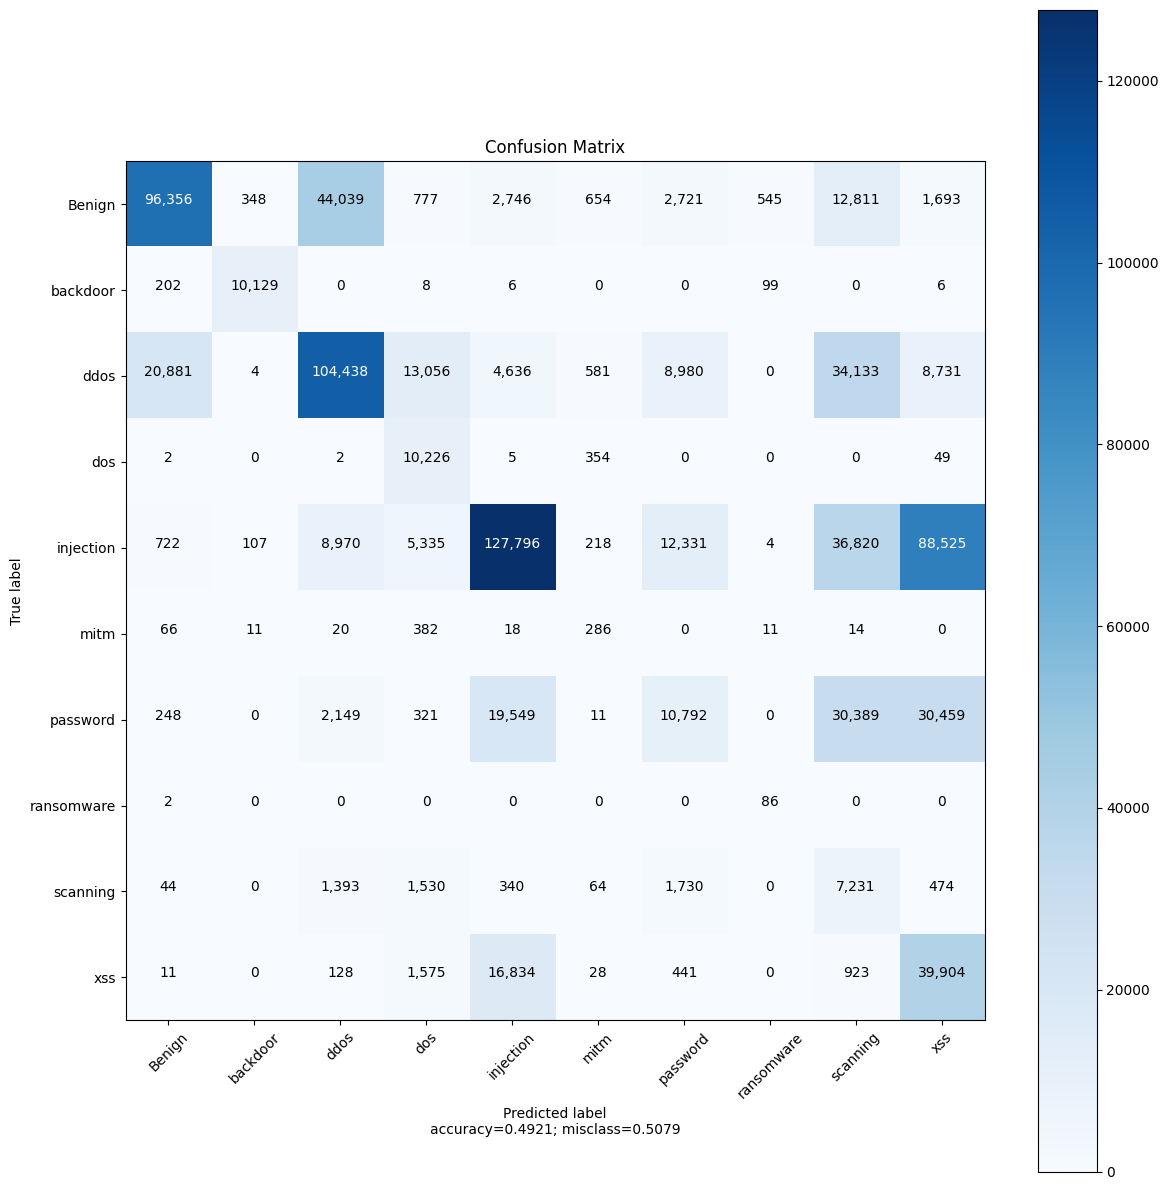

In [41]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
plot_confusion_matrix(cm = confusion_matrix(actual, le.inverse_transform(predicted_classes.cpu())),
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")

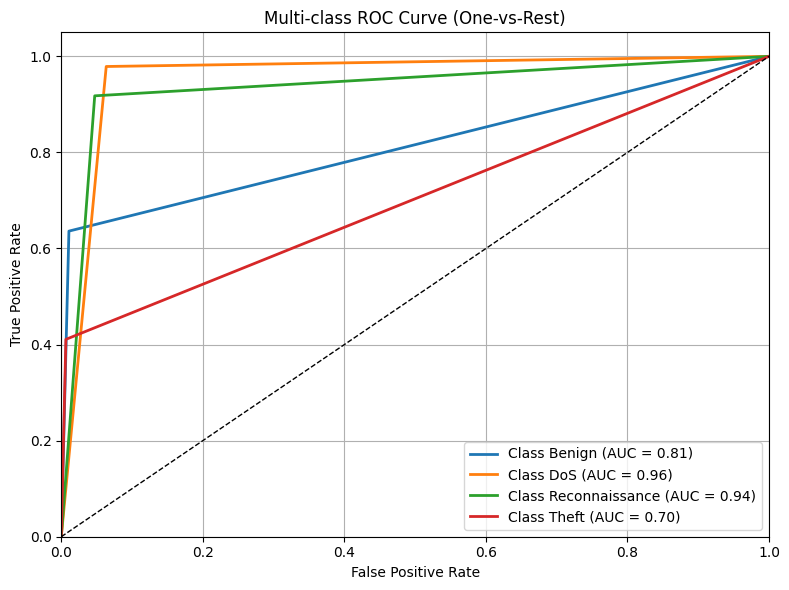

In [ ]:
X = actual
y = le.inverse_transform(predicted_classes.cpu())
classes = np.unique(actual)
n_classes = len(classes)

X_bin = label_binarize(X, classes=classes)  # shape: (n_samples, n_classes)
y_bin = label_binarize(y, classes=classes)  # shape: (n_samples, n_classes)

# 2. Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(X_bin[:, i], y_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")

# 3. Add plot decorations
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# OvA - With Class wise features

In [55]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to output fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats,efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        # ipdb.set_trace()
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.classifiers = nn.ModuleList([nn.Linear(in_features * 2, out_classes) for _ in range(10)])

    def apply_edges(self, edges, class_idx, apply_sigmoid=False):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        logits = self.classifiers[class_idx](th.cat([h_u, h_v], 1))
        # if apply_sigmoid:
        #     score = logits[:,1] #torch.sigmoid(logits)[:,1]
        # else:
        #     score = logits
        score = logits
        return {'score': score}
    def forward(self, graph, h, class_idx=None):
        with graph.local_scope():
            graph.ndata['h'] = h
            if class_idx is not None:
              graph.apply_edges(lambda edges: self.apply_edges(edges, class_idx,apply_sigmoid=False))
              return graph.edata['score']
            else:
              outputs = []
              for i in range(len(self.classifiers)):
                  graph.apply_edges(lambda edges: self.apply_edges(edges, i,apply_sigmoid=True))
                  outputs.append(graph.edata['score'])
              return torch.stack(outputs, dim=1)

class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 1)
    def forward(self, g, nfeats,efeats, edge_weight=None, feature_weight=None,class_idx=None):
      h = self.gnn(g, nfeats,efeats)
      # return self.pred(g, h)
      if class_idx is not None:
        return self.pred(g, h, class_idx)
      else:
        # If no class specified, return predictions for all classes (used for evaluation)
        return self.pred(g, h)

In [56]:
class_weights_list = []
for i in range(10):
    binary_labels = (G.edata['label'].cpu().numpy() == i).astype(int)
    class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                  classes= np.unique(binary_labels),
                                                  y= binary_labels)
    class_weights = th.FloatTensor(class_weights).cuda()
    class_weights_list.append(class_weights)
class_weights_list

[tensor([ 0.5194, 13.3700], device='cuda:0'),
 tensor([0.6079, 2.8178], device='cuda:0'),
 tensor([ 0.5123, 20.8574], device='cuda:0'),
 tensor([ 0.5130, 19.6996], device='cuda:0'),
 tensor([0.5830, 3.5103], device='cuda:0'),
 tensor([0.6862, 1.8427], device='cuda:0'),
 tensor([ 0.5261, 10.0671], device='cuda:0'),
 tensor([0.5280, 9.4383], device='cuda:0'),
 tensor([0.5381, 7.0697], device='cuda:0'),
 tensor([0.5873, 3.3631], device='cuda:0')]

In [57]:
def train_one_vs_all(model,graph,nfeats, efeats, labels, train_mask, optimizer, num_classes, selected_features_per_class):
    model.train()
    losses = []

    # For each class, train the corresponding binary classifier
    for class_idx in range(num_classes):
        # print(class_idx)
        optimizer.zero_grad()
        selected_efeatures = efeats[:, :, selected_features_per_class[class_idx]]
        selected_nfeatures = nfeats[:, :, selected_features_per_class[class_idx]]

        # Forward pass
        outputs = model(graph, selected_nfeatures, selected_efeatures,class_idx=class_idx).cuda()

        #using BCELoss Function
        binary_labels = (labels == class_idx).float()
        criterion = nn.BCEWithLogitsLoss(pos_weight=th.tensor([class_weights_list[class_idx][1]], device=outputs.device))
        loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        del outputs,binary_labels, loss
        th.cuda.empty_cache()

    avg_loss = np.mean(losses)
    return avg_loss


In [58]:
def predict_one_vs_all(model,graph,nfeats, efeats,selected_features_per_class):
    model.eval()

    with th.no_grad():
        outputs = []
        for class_idx in range(10):
          selected_efeatures = efeats[:, :, selected_features_per_class[class_idx]]
          selected_nfeatures = nfeats[:, :, selected_features_per_class[class_idx]]

          logits = model(graph, selected_nfeatures, selected_efeatures, class_idx=class_idx).cuda()

          outputs.append(logits)#torch.sigmoid(logits)[:,0]

        outputs = th.stack(outputs, dim=1)  # Shape: (num_nodes, num_classes)
        predicted_classes = th.argmax(outputs, dim=1)  # Select the class with the highest score

    return predicted_classes

# nfeats = G_test.ndata['feature']
# efeats = G_test.edata['h']
# predicted_classes = predict_one_vs_all(model,G_test, nfeats ,efeats)
# predicted_classes.unique()

In [59]:
# selected_features_per_class=final_features
# for e -gnn
selected_features_per_class_gnn ={0: [2, 6, 4, 1, 5, 7, 0, 3], 1: [3, 5, 1, 6, 7, 0, 4, 2], 2: [1, 5, 6, 0, 7, 4, 2, 3], 3: [5, 3, 0, 4, 6, 1, 2, 7]}

#for e-pg
selected_features_per_class_pg = {0: [34, 72, 49, 54, 12, 24, 45, 39, 57, 25, 71, 67, 46, 27, 18, 70, 56, 16, 11, 68, 17, 9, 6, 32, 69, 23, 40, 14, 30, 22, 0, 36, 66, 41, 73, 64, 1, 63, 5, 20, 74, 55, 60, 10, 38, 50, 31, 53, 2, 51, 3, 47, 15, 44, 48, 4, 8, 21, 7, 29, 13, 59, 37, 28, 42, 65, 33, 35, 61, 43, 58, 26, 75, 62, 19, 52], 1: [43, 61, 54, 70, 48, 39, 74, 36, 17, 9, 12, 63, 10, 58, 4, 67, 69, 46, 40, 0, 13, 53, 8, 42, 59, 25, 2, 16, 29, 5, 55, 52, 45, 23, 64, 15, 44, 62, 38, 31, 21, 27, 75, 73, 68, 56, 34, 33, 22, 18, 51, 24, 30, 20, 35, 3, 60, 37, 72, 26, 11, 41, 7, 47, 66, 6, 50, 71, 19, 14, 1, 65, 49, 57, 28, 32], 2: [42, 25, 68, 13, 49, 4, 30, 59, 32, 58, 52, 41, 17, 47, 12, 31, 69, 64, 34, 29, 70, 15, 38, 11, 62, 26, 10, 8, 50, 18, 60, 75, 46, 19, 23, 9, 0, 22, 71, 1, 35, 57, 5, 51, 27, 53, 2, 21, 14, 54, 37, 28, 73, 45, 33, 7, 3, 61, 55, 40, 43, 24, 39, 56, 44, 66, 36, 48, 67, 63, 16, 20, 65, 6, 72, 74], 3: [21, 51, 3, 71, 55, 59, 50, 11, 52, 62, 34, 12, 7, 33, 16, 24, 42, 30, 48, 53, 38, 2, 18, 36, 1, 39, 64, 75, 22, 66, 43, 4, 74, 37, 65, 23, 70, 29, 0, 69, 54, 72, 40, 49, 41, 63, 73, 25, 17, 5, 10, 56, 8, 6, 57, 28, 13, 67, 26, 19, 31, 68, 47, 61, 32, 58, 20, 35, 14, 27, 15, 45, 44, 9, 46, 60], 4: [18, 56, 47, 10, 30, 25, 59, 63, 22, 54, 71, 67, 62, 44, 74, 24, 43, 27, 45, 29, 48, 41, 61, 32, 49, 0, 5, 33, 23, 3, 16, 13, 38, 57, 17, 26, 7, 2, 8, 75, 19, 15, 21, 46, 68, 28, 69, 60, 73, 6, 64, 51, 20, 9, 34, 65, 42, 53, 39, 11, 55, 66, 36, 31, 4, 72, 58, 37, 1, 70, 14, 35, 50, 40, 12, 52], 5: [24, 70, 30, 22, 68, 61, 63, 75, 11, 64, 55, 45, 42, 26, 32, 17, 21, 6, 38, 54, 19, 23, 60, 28, 8, 50, 36, 27, 0, 14, 12, 49, 44, 13, 29, 5, 25, 3, 16, 2, 48, 67, 7, 18, 41, 69, 40, 33, 66, 43, 73, 72, 34, 46, 56, 20, 65, 74, 51, 71, 58, 1, 57, 52, 53, 35, 39, 62, 4, 31, 9, 15, 10, 59, 47, 37], 6: [32, 69, 24, 26, 47, 51, 6, 53, 73, 49, 22, 42, 74, 3, 68, 45, 28, 59, 20, 38, 46, 5, 55, 40, 36, 4, 70, 63, 17, 52, 58, 34, 44, 14, 27, 66, 23, 56, 41, 0, 50, 72, 61, 67, 31, 62, 43, 21, 48, 65, 64, 37, 18, 19, 29, 25, 39, 35, 11, 16, 8, 33, 15, 12, 2, 54, 57, 13, 75, 71, 10, 1, 60, 7, 9, 30], 7: [1, 21, 41, 37, 67, 0, 6, 59, 28, 64, 29, 50, 74, 3, 38, 62, 42, 31, 58, 17, 53, 72, 39, 10, 7, 24, 61, 18, 55, 33, 52, 2, 47, 15, 48, 13, 71, 20, 5, 44, 57, 12, 27, 68, 9, 14, 70, 75, 40, 46, 11, 43, 34, 35, 32, 60, 66, 4, 51, 16, 54, 8, 23, 22, 30, 69, 56, 49, 26, 45, 73, 65, 63, 25, 36, 19], 8: [57, 60, 3, 47, 25, 73, 70, 16, 41, 74, 0, 20, 9, 42, 49, 12, 59, 26, 2, 17, 48, 34, 69, 72, 71, 68, 63, 24, 18, 36, 14, 43, 10, 50, 51, 37, 31, 1, 22, 52, 21, 46, 54, 11, 38, 8, 39, 61, 33, 66, 65, 55, 30, 27, 19, 62, 53, 32, 7, 28, 40, 64, 5, 29, 67, 15, 6, 58, 56, 44, 35, 45, 75, 23, 13, 4], 9: [30, 62, 16, 26, 42, 57, 71, 43, 0, 24, 58, 46, 6, 49, 37, 28, 74, 31, 52, 18, 17, 7, 54, 19, 10, 29, 5, 61, 9, 34, 33, 70, 27, 40, 60, 21, 48, 41, 50, 55, 22, 75, 69, 3, 11, 8, 68, 72, 73, 14, 2, 4, 64, 44, 12, 36, 35, 66, 59, 20, 65, 53, 23, 39, 38, 25, 47, 67, 51, 15, 63, 32, 1, 56, 13, 45]}

In [ ]:
#PGExplainer 7 features
nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

selected_features_per_class =selected_features_per_class_gnn
df_ova_results=[]

for num in range(8,4,-1): #8,0,-1
  model = Model(num, 128, num, F.relu, 0.2).cuda()
  opt = th.optim.Adam(model.parameters())

  selected_features_per_class_r = {}
  for key in selected_features_per_class:
    selected_features_per_class_r[key] = selected_features_per_class[key][:num]

  # train_losses = []
  for epoch in range(1,150):#200
      avg_loss = train_one_vs_all(model,G,nfeats, efeats,  edge_label, train_mask, opt, 4,selected_features_per_class_r)
      # train_losses.append(avg_loss)

  nfeats_test = G_test.ndata['feature']
  efeats_test = G_test.edata['h']
  actual = G_test.edata['label']
  predicted_classes = predict_one_vs_all(model,G_test, nfeats_test ,efeats_test,selected_features_per_class_r)

  report = classification_report(actual.cpu(), predicted_classes.cpu(), output_dict=True)

  df_ova_results.append(
      {
        'features': num,
        # 'acc': report['accuracy'],
        'f1_macro': report['weighted avg']['f1-score'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall']
    }
  )

  # del model
df_ova_results = pd.DataFrame(df_ova_results)
#todo append egraphsage / for all features ova


/tmp/ipython-input-117-147214995.py:17: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/tmp/ipython-input-117-147214995.py:17: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserW

In [ ]:
df_ova_results

,features,f1_macro,precision,recall
0,8,0.923644,0.934425,0.919569
1,7,0.918894,0.934502,0.913606
2,6,0.925467,0.935468,0.921782
3,5,0.916671,0.932932,0.910054
4,4,0.916497,0.932908,0.909151
5,3,0.916238,0.925677,0.913251
6,2,0.922558,0.932574,0.919400
7,1,0.881166,0.915204,0.868433


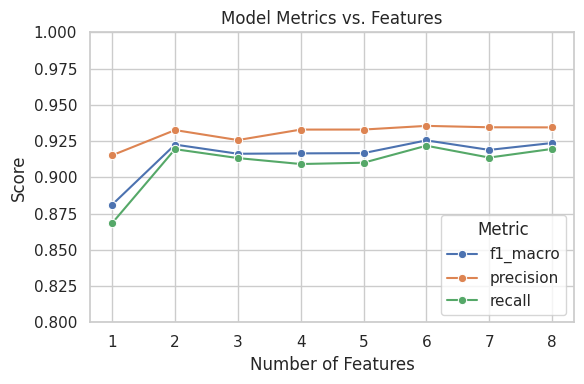

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the DataFrame to have one row per metric
df_melted = df_ova_results.melt(id_vars='features',
                    value_vars=['f1_macro', 'precision', 'recall'],
                    var_name='Metric', value_name='Score')

# Plot
import seaborn as sns
sns.set(style='whitegrid')

plt.figure(figsize=(6, 4))
sns.lineplot(data=df_melted, x='features', y='Score', hue='Metric', marker='o')

plt.title('Model Metrics vs. Features')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.ylim(0.8, 1)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

In [ ]:
df_ova_results

,features,f1_macro,precision,recall
0,8,0.922021,0.932665,0.917945
1,7,0.920364,0.931868,0.915842
2,6,0.916812,0.931629,0.910627
3,5,0.919109,0.931609,0.914054


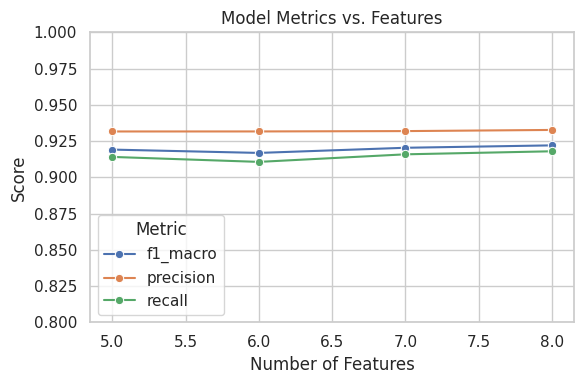

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the DataFrame to have one row per metric
df_melted = df_ova_results.melt(id_vars='features',
                    value_vars=['f1_macro', 'precision', 'recall'],
                    var_name='Metric', value_name='Score')

# Plot
import seaborn as sns
sns.set(style='whitegrid')

plt.figure(figsize=(6, 4))
sns.lineplot(data=df_melted, x='features', y='Score', hue='Metric', marker='o')

plt.title('Model Metrics vs. Features')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.ylim(0.8, 1)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

## With E-PGExplainer

In [64]:
len(selected_features_per_class_pg[0])

76

In [67]:
#PGExplainer 7 features
nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

selected_features_per_class =selected_features_per_class_pg
df_ova_results=[]

for num in range(76,45,-5):
  print(num)
  model = Model(num, 128, num, F.relu, 0.2).cuda()
  opt = th.optim.Adam(model.parameters())

  selected_features_per_class_r = {}
  for key in selected_features_per_class:
    selected_features_per_class_r[key] = selected_features_per_class[key][:num]

  # train_losses = []
  for epoch in range(1,100):#200
      avg_loss = train_one_vs_all(model,G,nfeats, efeats,  edge_label, train_mask, opt, 10,selected_features_per_class_r)
      if epoch%20==0:
          print(avg_loss)
      # train_losses.append(avg_loss)

  nfeats_test = G_test.ndata['feature']
  efeats_test = G_test.edata['h']
  actual = G_test.edata['label']
  predicted_classes = predict_one_vs_all(model,G_test, nfeats_test ,efeats_test,selected_features_per_class_r)

  report = classification_report(actual.cpu(), predicted_classes.cpu(), output_dict=True)

  df_ova_results.append(
      {
        'features': num,
        # 'acc': report['accuracy'],
        'f1_macro': report['weighted avg']['f1-score'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall']
    }
  )

  print(num, report)

  # del model
df_ova_results = pd.DataFrame(df_ova_results)
#todo append egraphsage / for all features ova


76
0.37263914281502364
0.2910466779023409
0.26665188018232583
0.21008832858642562
76 {'0': {'precision': 0.7398917542184018, 'recall': 0.7942583732057417, 'f1-score': 0.7661117521015328, 'support': 5852.0}, '1': {'precision': 0.9758269720101781, 'recall': 0.9544549527127925, 'f1-score': 0.9650226472068445, 'support': 28126.0}, '2': {'precision': 0.8538812785388128, 'recall': 0.964414646725116, 'f1-score': 0.9057883264713006, 'support': 3878.0}, '3': {'precision': 0.9966052376333656, 'recall': 1.0, 'f1-score': 0.9982997328151566, 'support': 4110.0}, '4': {'precision': 0.7477110885045778, 'recall': 0.03299811439346323, 'f1-score': 0.06320677645440083, 'support': 22274.0}, '5': {'precision': 0.7855238876358417, 'recall': 0.6189871664666236, 'f1-score': 0.6923821695519151, 'support': 43324.0}, '6': {'precision': 0.1958309328025978, 'recall': 0.9261828090165964, 'f1-score': 0.32330306960657157, 'support': 8074.0}, '7': {'precision': 0.987721021611002, 'recall': 0.9948058372495672, 'f1-score

In [68]:
df_ova_results

,features,f1_macro,precision,recall
0,76,0.727104,0.841625,0.734234
1,71,0.717537,0.778380,0.782014
2,66,0.497059,0.771364,0.500422
3,61,0.467369,0.728180,0.476258
4,56,0.571871,0.677651,0.633535
5,51,0.546239,0.789979,0.582619
6,46,0.459098,0.761170,0.482203


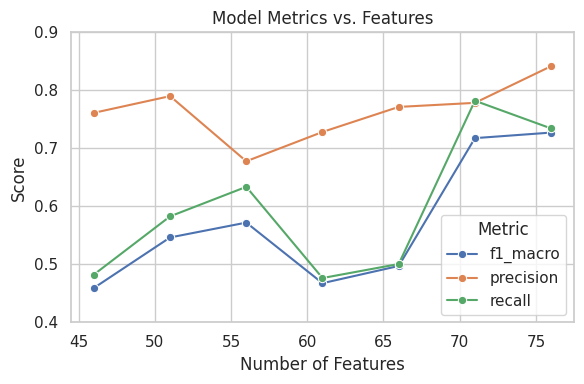

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the DataFrame to have one row per metric
df_melted = df_ova_results.melt(id_vars='features',
                    value_vars=['f1_macro', 'precision', 'recall'],
                    var_name='Metric', value_name='Score')

# Plot
import seaborn as sns
sns.set(style='whitegrid')

plt.figure(figsize=(6, 4))
sns.lineplot(data=df_melted, x='features', y='Score', hue='Metric', marker='o')

plt.title('Model Metrics vs. Features')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.ylim(0.40, 0.90)
plt.legend(title='Metric')
plt.tight_layout()
# plt.savefig("/scratch/kc01/na3038/TrainedModels/plot.png")
plt.show()

In [71]:
nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

selected_features_per_class =selected_features_per_class_pg
df_ova_results=[]

num=71
model = Model(num, 128, num, F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

start_time = timeit.default_timer()

selected_features_per_class_r = {}
for key in selected_features_per_class:
  selected_features_per_class_r[key] = selected_features_per_class[key][:num]

# train_losses = []
for epoch in range(1,400):#200
  avg_loss = train_one_vs_all(model,G,nfeats, efeats,  edge_label, train_mask, opt, 10,selected_features_per_class_r)
  if epoch%20==0:
      print(avg_loss)
  # train_losses.append(avg_loss)

elapsed = timeit.default_timer() - start_time
print(str(elapsed) + ' seconds')

0.36477120080962777
0.37701131515204905
0.28844436979852617
0.25758934071054684
0.2030161908827722
0.19156561070121825
0.19421696559875273
0.18217524694046006
0.15852184249670245
0.20011237633880227
0.17896071710274555
0.19301188457757235
0.14673744369647465
0.16490966712008231
0.14104871794988866
0.1419854339270387
0.1365946841513505
0.2502829622477293
0.17118373373523355
261.5660957880318 seconds


/jobfs/151308696.gadi-pbs/ipykernel_3739684/2487024200.py:18: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


0.3689697664231062
0.2865148299606517
0.2529229598352686
0.22625857022358103
0.21729111316381022
0.23728078184649348
0.19354918554308825
0.17336212570080534
0.16211914835148492
0.15567495168070308
0.15645091146579942
0.18741854992695153
0.15885871200589463
0.15337048918008805
201.10740060498938 seconds


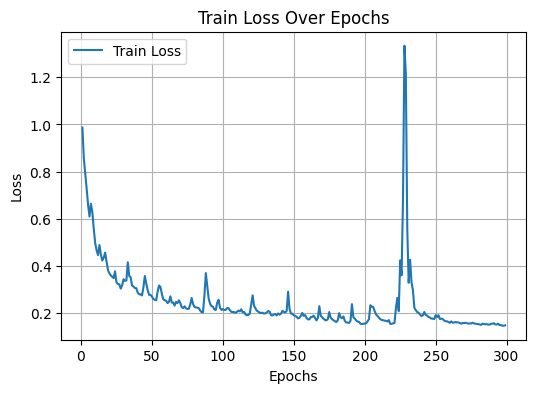

In [60]:
nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

selected_features_per_class =selected_features_per_class_pg
df_ova_results=[]

num=71
model = Model(num, 128, num, F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

start_time = timeit.default_timer()

selected_features_per_class_r = {}
for key in selected_features_per_class:
  selected_features_per_class_r[key] = selected_features_per_class[key][:num]

train_losses = []
for epoch in range(1,300):
  avg_loss = train_one_vs_all(model,G,nfeats, efeats,  edge_label, train_mask, opt, 10,selected_features_per_class_r)
  if epoch%20==0:
      print(avg_loss)
  train_losses.append(avg_loss)

# train_losses =  [tensor.cpu().detach().numpy() for tensor in train_losses]

elapsed = timeit.default_timer() - start_time
print(str(elapsed) + ' seconds')


epochs = range(1, 300)
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

selected_features_per_class =selected_features_per_class_pg
df_ova_results=[]

num=71
model = Model(num, 128, num, F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

start_time = timeit.default_timer()

selected_features_per_class_r = {}
for key in selected_features_per_class:
  selected_features_per_class_r[key] = selected_features_per_class[key][:num]

# train_losses = []
for epoch in range(1,200):#200
  avg_loss = train_one_vs_all(model,G,nfeats, efeats,  edge_label, train_mask, opt, 10,selected_features_per_class_r)
  if epoch%20==0:
      print(avg_loss)
  # train_losses.append(avg_loss)

elapsed = timeit.default_timer() - start_time
print(str(elapsed) + ' seconds')

/jobfs/151308696.gadi-pbs/ipykernel_3739684/2487024200.py:18: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


0.3498141597025096
0.3322488132864237
0.2388258967315778
0.22050787679618225
0.20478875233093277
0.22080205851234497
0.18921269567217677
0.18468225026736035
0.17210661131539381
132.8410405209288 seconds


In [23]:
nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

selected_features_per_class =selected_features_per_class_pg
df_ova_results=[]

num=71
model = Model(num, 128, num, F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

start_time = timeit.default_timer()

selected_features_per_class_r = {}
for key in selected_features_per_class:
  selected_features_per_class_r[key] = selected_features_per_class[key][:num]

# train_losses = []
for epoch in range(1,100):#100
  avg_loss = train_one_vs_all(model,G,nfeats, efeats,  edge_label, train_mask, opt, 10,selected_features_per_class_r)
  if epoch%20==0:
      print(avg_loss)
  # train_losses.append(avg_loss)

elapsed = timeit.default_timer() - start_time
print(str(elapsed) + ' seconds')

/jobfs/151308696.gadi-pbs/ipykernel_3739684/2487024200.py:18: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


0.3421272668987513
0.28973628701642157
0.26722757490351795
0.22930206680903212
65.82853979198262 seconds


In [2]:
# Print a detailed report for each class- 400 epoches
# 0.17983573861420155 seconds
# Class          Precision Recall    F2-score  Accuracy  Support   
# =================================================================
# Benign         0.1649    0.9120    0.2794    0.9120    5852      
# DNS Flood      0.9946    0.0658    0.1235    0.0658    28126     
# Dictionary Attack0.9324    0.9887    0.9597    0.9887    3878      
# ICMP Flood     0.9966    0.9995    0.9981    0.9995    4110      
# OS Scan        0.5267    0.1103    0.1824    0.1103    22274     
# Ping Sweep     0.6961    0.2845    0.4039    0.2845    43324     
# Port Scan      0.1481    0.9365    0.2557    0.9365    8074      
# SYN Flood      0.9958    0.9864    0.9911    0.9864    8086      
# Slowloris      0.9728    0.9677    0.9702    0.9677    11082     
# Vulnerability Scan0.9871    0.9820    0.9845    0.9820    23984     

# Overall Accuracy:
# Accuracy: 0.5021

# Weighted Averages:
# {'precision': 0.7698277878177975, 'recall': 0.50209710938976, 'f1-score': 0.49712380900768566, 'support': 158790.0}


In [1]:
# Print a detailed report for each class- 200 epoches
# 0.23204854293726385 seconds
# Class          Precision Recall    F2-score  Accuracy  Support   
# =================================================================
# Benign         0.7446    0.8845    0.8086    0.8845    5852      
# DNS Flood      0.9933    0.9740    0.9836    0.9740    28126     
# Dictionary Attack0.9344    0.9776    0.9555    0.9776    3878      
# ICMP Flood     0.9973    0.9995    0.9984    0.9995    4110      
# OS Scan        0.3466    0.3179    0.3316    0.3179    22274     
# Ping Sweep     0.6884    0.0378    0.0717    0.0378    43324     
# Port Scan      0.1497    0.9320    0.2580    0.9320    8074      
# SYN Flood      0.9877    0.9948    0.9913    0.9948    8086      
# Slowloris      0.9808    0.9609    0.9707    0.9609    11082     
# Vulnerability Scan0.9804    0.9816    0.9810    0.9816    23984     

# Overall Accuracy:
# Accuracy: 0.6232

# Weighted Averages:
# {'precision': 0.7628896994500226, 'recall': 0.6231563700484917, 'f1-score': 0.5987962142490665, 'support': 158790.0}

In [16]:
# Print a detailed report for each class- 100 epoches
start_time = timeit.default_timer()
nfeats_test = G_test.ndata['feature']
efeats_test = G_test.edata['h']
# actual = G_test.edata['label']
predicted_classes = predict_one_vs_all(model,G_test, nfeats_test ,efeats_test,selected_features_per_class_r)
elapsed = timeit.default_timer() - start_time
print(str(elapsed) + ' seconds')

# actual=le.inverse_transform(actual.cpu())
test_pred= le.inverse_transform(predicted_classes.squeeze().cpu())
report = classification_report(actual, test_pred, output_dict=True)

header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.4f}{metrics['recall']:<10.4f}{metrics['f1-score']:<10.4f}{accuracy:<10.4f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.4f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

0.18922652397304773 seconds
Class          Precision Recall    F2-score  Accuracy  Support   
Benign         0.8084    0.7521    0.7792    0.7521    5852      
DNS Flood      0.9694    0.9868    0.9780    0.9868    28126     
Dictionary Attack0.8897    0.9691    0.9277    0.9691    3878      
ICMP Flood     0.9825    1.0000    0.9912    1.0000    4110      
OS Scan        0.7533    0.0254    0.0491    0.0254    22274     
Ping Sweep     0.7444    0.9918    0.8505    0.9918    43324     
Port Scan      0.4859    0.9043    0.6321    0.9043    8074      
SYN Flood      0.9864    0.9871    0.9868    0.9871    8086      
Slowloris      0.9343    0.9332    0.9338    0.9332    11082     
Vulnerability Scan0.9762    0.9625    0.9693    0.9625    23984     

Overall Accuracy:
Accuracy: 0.8330

Weighted Averages:
{'precision': 0.8450209598736022, 'recall': 0.832974368663014, 'f1-score': 0.7831555296762885, 'support': 158790.0}


In [61]:
# Print a detailed report for each class- 300 epoches
start_time = timeit.default_timer()
nfeats_test = G_test.ndata['feature']
efeats_test = G_test.edata['h']
# actual = G_test.edata['label']
predicted_classes = predict_one_vs_all(model,G_test, nfeats_test ,efeats_test,selected_features_per_class_r)
elapsed = timeit.default_timer() - start_time
print(str(elapsed) + ' seconds')

# actual=le.inverse_transform(actual.cpu())
test_pred= le.inverse_transform(predicted_classes.squeeze().cpu())
report = classification_report(actual, test_pred, output_dict=True)

header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.4f}{metrics['recall']:<10.4f}{metrics['f1-score']:<10.4f}{accuracy:<10.4f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.4f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

0.28036861307919025 seconds
Class          Precision Recall    F2-score  Accuracy  Support   
Benign         0.1798    0.9368    0.3017    0.9368    5852      
DNS Flood      0.9872    0.1314    0.2319    0.1314    28126     
Dictionary Attack0.9500    0.9887    0.9689    0.9887    3878      
ICMP Flood     0.9966    0.9995    0.9981    0.9995    4110      
OS Scan        0.5581    0.1076    0.1804    0.1076    22274     
Ping Sweep     0.7051    0.2968    0.4178    0.2968    43324     
Port Scan      0.1499    0.9412    0.2586    0.9412    8074      
SYN Flood      0.9852    0.9993    0.9922    0.9993    8086      
Slowloris      0.9845    0.9770    0.9807    0.9770    11082     
Vulnerability Scan0.9827    0.9824    0.9826    0.9824    23984     

Overall Accuracy:
Accuracy: 0.5192

Weighted Averages:
{'precision': 0.7760835213102303, 'recall': 0.5192014610491844, 'f1-score': 0.5215120669237874, 'support': 158790.0}


In [70]:
0.1892 *1000000/158790

1.1915108004282386

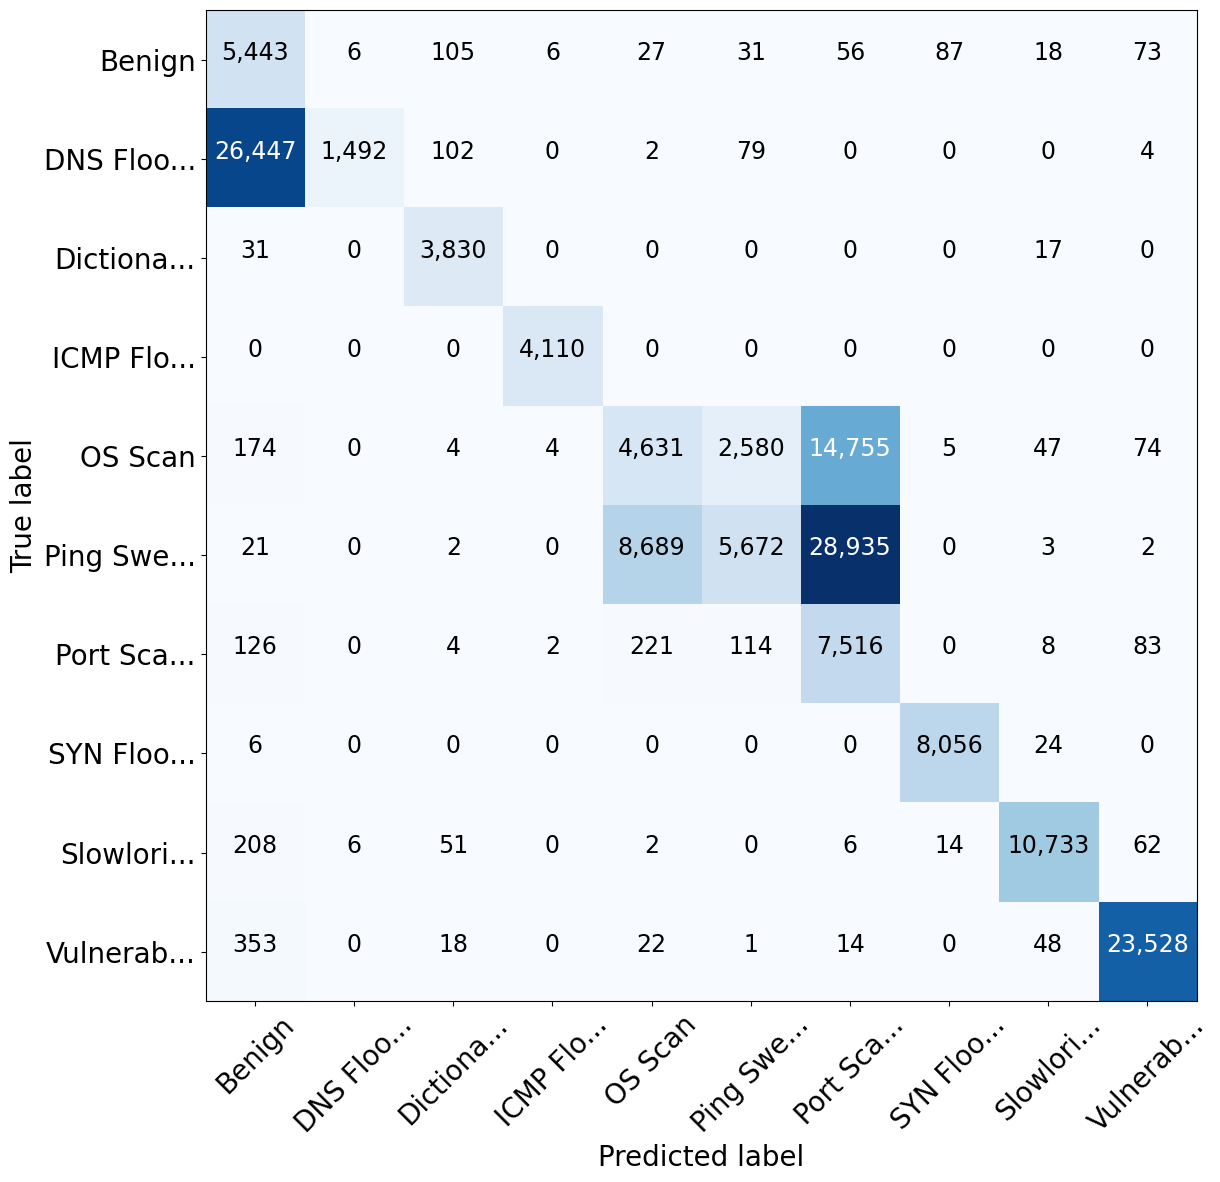

In [52]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          # title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          fontsize=20,
                          text_fontsize=17):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title,fontsize=fontsize + 2)
    # plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45,fontsize=fontsize)
        plt.yticks(tick_marks, target_names,fontsize=fontsize)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=text_fontsize,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     fontsize=text_fontsize,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label',fontsize=fontsize)
    plt.xlabel('Predicted label',fontsize=fontsize)
    plt.subplots_adjust(left=0.15, bottom=0.15)
    plt.savefig('/scratch/kc01/na3038/TrainedModels/ton/proposed-cm.png',bbox_inches='tight')
    plt.show()
max_label_len = 8  # adjust as needed
target_names = np.unique(actual)
truncated_target_names = [
    f"{label[:max_label_len]}..." if len(label) > max_label_len else label
    for label in target_names
]
plot_confusion_matrix(cm = confusion_matrix(actual, test_pred),
                      normalize    = False,
                      target_names = truncated_target_names,
                      # title        = "Confusion Matrix"
                      )

In [ ]:
predicted_classes.cpu().unique()

tensor([0, 1, 2, 3])

/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


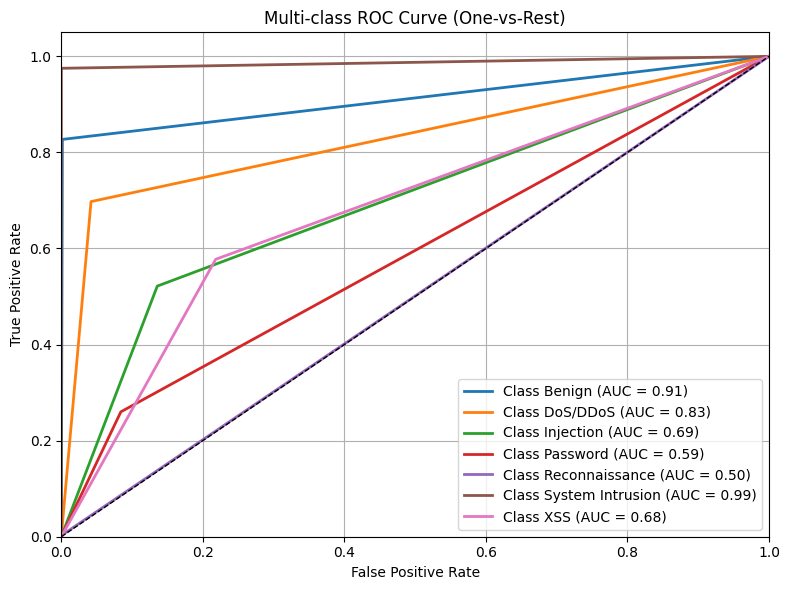

In [22]:
X = actual
y = le.inverse_transform(predicted_classes.cpu())
classes = np.unique(actual)
n_classes = len(classes)

X_bin = label_binarize(X, classes=classes)  # shape: (n_samples, n_classes)
y_bin = label_binarize(y, classes=classes)  # shape: (n_samples, n_classes)

# 2. Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(X_bin[:, i], y_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")

# 3. Add plot decorations
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
